In [1]:
# for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for prediction models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# plt.style.use("fivethirtyeight")
pal = sns.color_palette()
pal_list = list(pal)

# for image study
import torch
import datetime as dt
import os
import tqdm


#### Import Dataset

In [17]:
pip install xgboost

In [2]:
items = pd.read_csv('items.csv')
restaurants = pd.read_csv('resturants.csv')
sales = pd.read_csv('sales.csv')

#### Examine the datasets

In [5]:
sales.info()
items.info()
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        109600 non-null  object 
 1   item_id     109600 non-null  int64  
 2   price       109600 non-null  float64
 3   item_count  109600 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        100 non-null    int64  
 1   store_id  100 non-null    int64  
 2   name      100 non-null    object 
 3   kcal      100 non-null    int64  
 4   cost      100 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
--

## Merging data to create a single data with date item id, price, item count, item names, kcal values, store id and store name.


In [16]:
sales.date = pd.to_datetime(sales.date)
sales.head(5)

date  item_id  price  item_count
0 2019-01-01        3  29.22         2.0
1 2019-01-01        4  26.42        22.0
2 2019-01-01       12   4.87         7.0
3 2019-01-01       13   4.18        12.0
4 2019-01-01       16   3.21       136.0

In [9]:
items.tail(5)

id  store_id                                               name  kcal  \
95   96         5                  Blue Ribbon Fish with Bread Lunch   708   
96   97         4  Original Fruity Cod with Bread and Vegetables ...   744   
97   98         2                    Original Sweet Milky Soft Drink   579   
98   99         4                           Frozen Tomato Soft Drink   423   
99  100         2                             Awesome Vodka Cocktail   223   

     cost  
95  21.93  
96  28.65  
97   5.00  
98   5.32  
99   2.48

In [11]:
sales.shape

(109600, 4)

In [18]:
merged_data = pd.merge(sales, items, left_on = "item_id", right_on = "id", how = "left")

In [21]:
restaurants

id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe
5   6        Surfs Up

In [14]:
merged_data.head(5)

date  item_id  price  item_count  id  store_id  \
0 2019-01-01        3  29.22         2.0   3         1   
1 2019-01-01        4  26.42        22.0   4         1   
2 2019-01-01       12   4.87         7.0  12         1   
3 2019-01-01       13   4.18        12.0  13         1   
4 2019-01-01       16   3.21       136.0  16         1   

                              name  kcal   cost  
0                Sweet Fruity Cake   931  29.22  
1  Amazing Steak Dinner with Rolls   763  26.42  
2             Fantastic Sweet Cola   478   4.87  
3          Sweet Frozen Soft Drink   490   4.18  
4             Frozen Milky Smoothy   284   3.21

In [25]:
merged_data.tail(5)

date  item_id  price  item_count   id  store_id  \
109595 2021-12-31       96  21.93         0.0   96         5   
109596 2021-12-31       97  28.65         0.0   97         4   
109597 2021-12-31       98   5.00         0.0   98         2   
109598 2021-12-31       99   5.32         0.0   99         4   
109599 2021-12-31      100   2.48         0.0  100         2   

                                                     name  kcal   cost  
109595                  Blue Ribbon Fish with Bread Lunch   708  21.93  
109596  Original Fruity Cod with Bread and Vegetables ...   744  28.65  
109597                    Original Sweet Milky Soft Drink   579   5.00  
109598                           Frozen Tomato Soft Drink   423   5.32  
109599                             Awesome Vodka Cocktail   223   2.48

In [23]:
data = pd.merge(merged_data, restaurants, left_on = 'store_id', right_on = 'id')

In [24]:
data.head(5)

date  item_id  price  item_count  id_x  store_id  \
0 2019-01-01        3  29.22         2.0     3         1   
1 2019-01-01        4  26.42        22.0     4         1   
2 2019-01-01       12   4.87         7.0    12         1   
3 2019-01-01       13   4.18        12.0    13         1   
4 2019-01-01       16   3.21       136.0    16         1   

                            name_x  kcal   cost  id_y       name_y  
0                Sweet Fruity Cake   931  29.22     1  Bob's Diner  
1  Amazing Steak Dinner with Rolls   763  26.42     1  Bob's Diner  
2             Fantastic Sweet Cola   478   4.87     1  Bob's Diner  
3          Sweet Frozen Soft Drink   490   4.18     1  Bob's Diner  
4             Frozen Milky Smoothy   284   3.21     1  Bob's Diner

In [26]:
data.tail(5)

date  item_id  price  item_count  id_x  store_id  \
109595 2021-12-31       96  21.93         0.0    96         5   
109596 2021-12-31       97  28.65         0.0    97         4   
109597 2021-12-31       98   5.00         0.0    98         2   
109598 2021-12-31       99   5.32         0.0    99         4   
109599 2021-12-31      100   2.48         0.0   100         2   

                                                   name_x  kcal   cost  id_y  \
109595                  Blue Ribbon Fish with Bread Lunch   708  21.93     5   
109596  Original Fruity Cod with Bread and Vegetables ...   744  28.65     4   
109597                    Original Sweet Milky Soft Drink   579   5.00     2   
109598                           Frozen Tomato Soft Drink   423   5.32     4   
109599                             Awesome Vodka Cocktail   223   2.48     2   

                name_y  
109595     Corner Cafe  
109596        Fou Cher  
109597  Beachfront Bar  
109598        Fou Cher  
109599  Beachfront Bar

In [27]:
(data.item_id == data.id_x).all()

True

In [28]:
(data.store_id == data.id_y).all()

True

## rename the columns for easier understanding and drop the duplicate columns

In [29]:
data.rename(columns = {"name_x" : "item_name", "name_y": "restaurant_name"}, inplace = True)

In [30]:
data.drop(columns = ['id_x', 'id_y', 'cost'], inplace = True)

In [31]:
data.head(5)

date  item_id  price  item_count  store_id  \
0 2019-01-01        3  29.22         2.0         1   
1 2019-01-01        4  26.42        22.0         1   
2 2019-01-01       12   4.87         7.0         1   
3 2019-01-01       13   4.18        12.0         1   
4 2019-01-01       16   3.21       136.0         1   

                         item_name  kcal restaurant_name  
0                Sweet Fruity Cake   931     Bob's Diner  
1  Amazing Steak Dinner with Rolls   763     Bob's Diner  
2             Fantastic Sweet Cola   478     Bob's Diner  
3          Sweet Frozen Soft Drink   490     Bob's Diner  
4             Frozen Milky Smoothy   284     Bob's Diner

In [32]:
data.tail(5)

date  item_id  price  item_count  store_id  \
109595 2021-12-31       96  21.93         0.0         5   
109596 2021-12-31       97  28.65         0.0         4   
109597 2021-12-31       98   5.00         0.0         2   
109598 2021-12-31       99   5.32         0.0         4   
109599 2021-12-31      100   2.48         0.0         2   

                                                item_name  kcal  \
109595                  Blue Ribbon Fish with Bread Lunch   708   
109596  Original Fruity Cod with Bread and Vegetables ...   744   
109597                    Original Sweet Milky Soft Drink   579   
109598                           Frozen Tomato Soft Drink   423   
109599                             Awesome Vodka Cocktail   223   

       restaurant_name  
109595     Corner Cafe  
109596        Fou Cher  
109597  Beachfront Bar  
109598        Fou Cher  
109599  Beachfront Bar

In [34]:
# Checking the details of the merged dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             109600 non-null  datetime64[ns]
 1   item_id          109600 non-null  int64         
 2   price            109600 non-null  float64       
 3   item_count       109600 non-null  float64       
 4   store_id         109600 non-null  int64         
 5   item_name        109600 non-null  object        
 6   kcal             109600 non-null  int64         
 7   restaurant_name  109600 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 6.7+ MB


In [40]:
# Checking null values

print(data.isnull().sum())

date               0
item_id            0
price              0
item_count         0
store_id           0
item_name          0
kcal               0
restaurant_name    0
dtype: int64


In [41]:
# Descriptive statistics

print(data.describe())

                      date        item_id          price     item_count  \
count               109600  109600.000000  109600.000000  109600.000000   
mean   2020-07-01 12:00:00      50.500000      11.763700       6.339297   
min    2019-01-01 00:00:00       1.000000       1.390000       0.000000   
25%    2019-10-01 18:00:00      25.750000       5.280000       0.000000   
50%    2020-07-01 12:00:00      50.500000       7.625000       0.000000   
75%    2021-04-01 06:00:00      75.250000      18.790000       0.000000   
max    2021-12-31 00:00:00     100.000000      53.980000     570.000000   
std                    NaN      28.866202       8.946225      30.003728   

           store_id           kcal  
count  109600.00000  109600.000000  
mean        3.52000     536.730000  
min         1.00000      78.000000  
25%         2.00000     406.250000  
50%         4.00000     572.500000  
75%         5.00000     638.250000  
max         6.00000    1023.000000  
std         1.69989     201.

Number of outliers: 1096


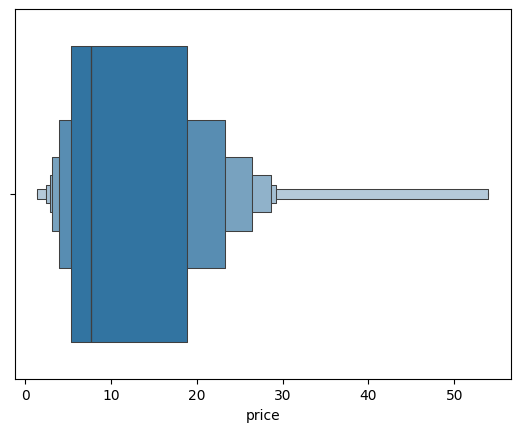

In [44]:

# Identify the outliers

Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Filter outliers
outliers = data[(data['price'] < Q1 - 1.5 * IQR) | (data['price'] > Q3 + 1.5 * IQR)]

print(f"Number of outliers: {len(outliers)}")

# Visualization of the distribution
sns.boxenplot(x=data['price'])
plt.show()

# Study overall sales date-wise to understand the sales pattern.

<ipython-input-51-a5494f562036>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='viridis')


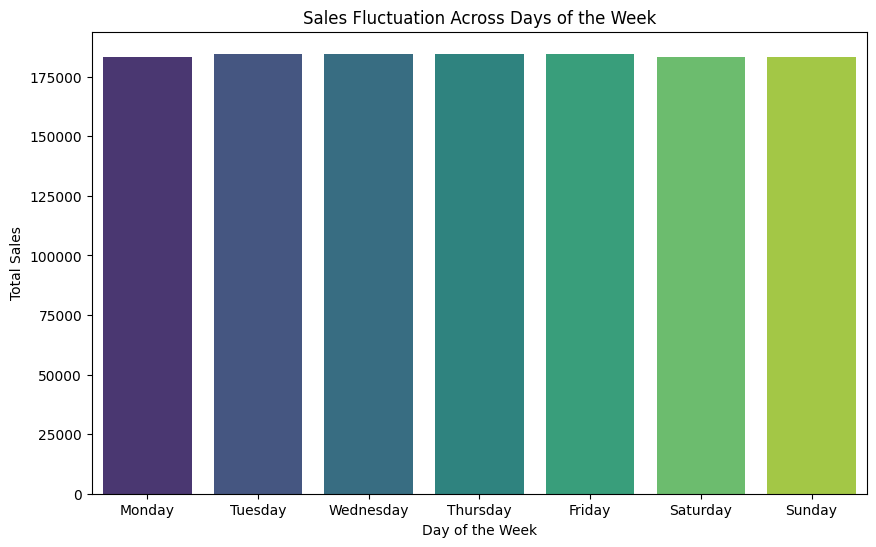

In [51]:


# Sales fluctuation Price-Wise

weekly_sales = data.groupby('day_of_week')['price'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='viridis')
plt.title('Sales Fluctuation Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

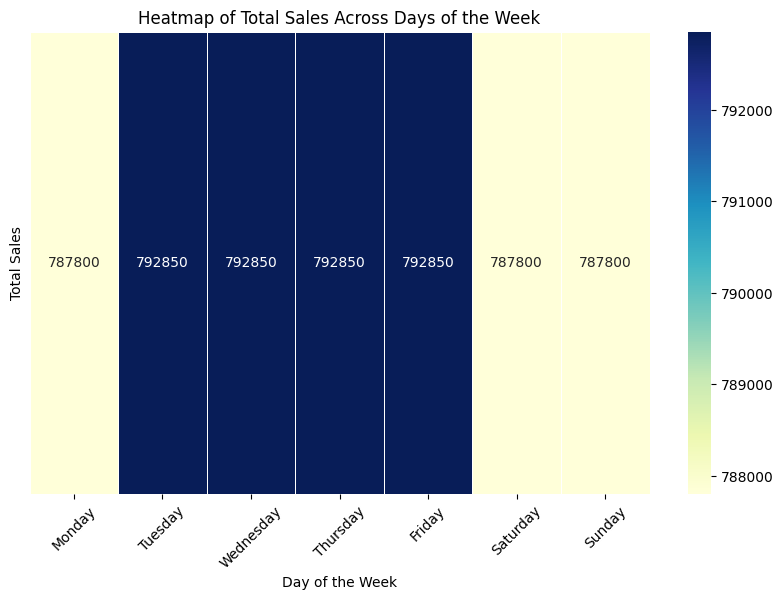

In [62]:
# Sales fluctuation Item-Wise

data['day_of_week'] = data['date'].dt.day_name()


heatmap_data = data.groupby('day_of_week')['item_id'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

heatmap_df = pd.DataFrame(heatmap_data).T

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".0f", cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Total Sales Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.yticks([], [])
plt.show()

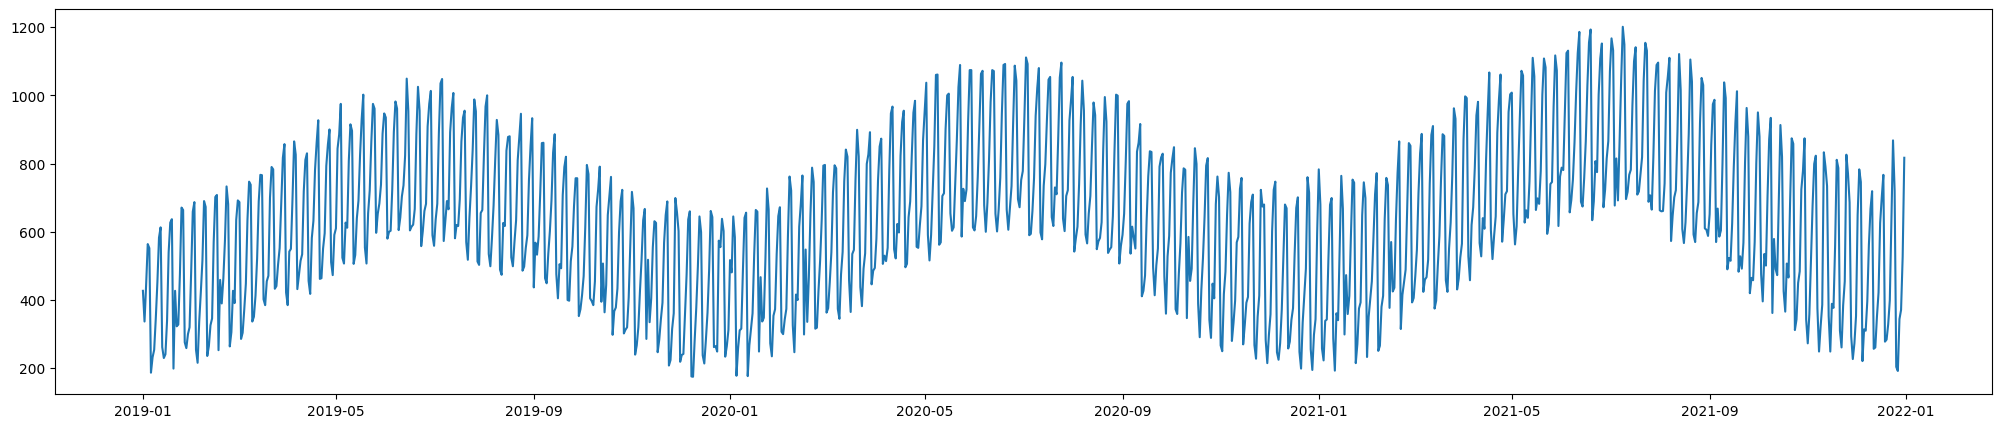

In [ ]:
grpd = sales.groupby(['date'])[['item_count']].sum()
plt.figure(figsize = (25,5))
plt.plot(grpd)
plt.show()

## Find out how the sales fluctuate across different days of the week?

In [53]:
data['weekday'] = data.date.dt.day_name()

In [54]:
import calendar
day_names = list(calendar.day_name)

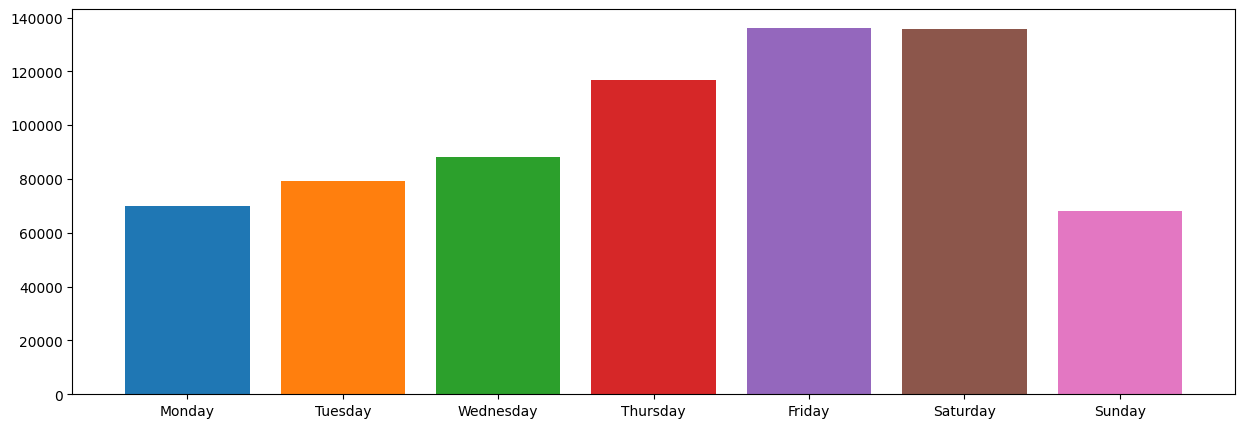

In [55]:
# Weekly sales fluctuation Item wise

grpd = data.groupby(['weekday'])[['item_count']].sum()
grpd = grpd.loc[day_names].squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.show()

## Look for any noticeable trends in the sales data for different months of the year.

In [113]:
data['month_name'] = data.date.dt.month_name()

In [114]:
months = list(calendar.month_name)[1:]

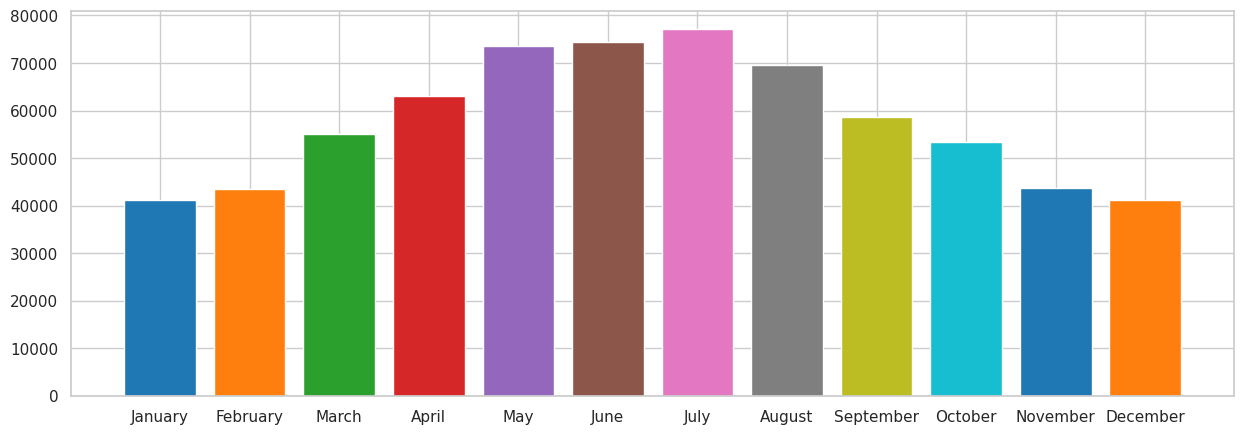

In [115]:
grpd = data.groupby(['month_name'])[['item_count']].sum()
grpd = grpd.loc[months].squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.show()

## Examine the distribution of sales across different quarters averaged over years. Identify any noticeablr pattern in sales.


In [77]:
data['quarter'] = data.date.dt.quarter

In [78]:
data

date  item_id  price  item_count  store_id  \
0      2019-01-01        3  29.22         2.0         1   
1      2019-01-01        4  26.42        22.0         1   
2      2019-01-01       12   4.87         7.0         1   
3      2019-01-01       13   4.18        12.0         1   
4      2019-01-01       16   3.21       136.0         1   
...           ...      ...    ...         ...       ...   
109595 2021-12-31       96  21.93         0.0         5   
109596 2021-12-31       97  28.65         0.0         4   
109597 2021-12-31       98   5.00         0.0         2   
109598 2021-12-31       99   5.32         0.0         4   
109599 2021-12-31      100   2.48         0.0         2   

                                                item_name  kcal  \
0                                       Sweet Fruity Cake   931   
1                         Amazing Steak Dinner with Rolls   763   
2                                    Fantastic Sweet Cola   478   
3                                 Sweet Frozen Soft Drink   490   
4                                    Frozen Milky Smoothy   284   
...                                                   ...   ...   
109595                  Blue Ribbon Fish with Bread Lunch   708   
109596  Original Fruity Cod with Bread and Vegetables ...   744   
109597                    Original Sweet Milky Soft Drink   579   
109598                           Frozen Tomato Soft Drink   423   
109599                             Awesome Vodka Cocktail   223   

       restaurant_name day_of_week  weekday  quarter  
0          Bob's Diner     Tuesday  Tuesday        1  
1          Bob's Diner     Tuesday  Tuesday        1  
2          Bob's Diner     Tuesday  Tuesday        1  
3          Bob's Diner     Tuesday  Tuesday        1  
4          Bob's Diner     Tuesday  Tuesday        1  
...                ...         ...      ...      ...  
109595     Corner Cafe      Friday   Friday        4  
109596        Fou Cher      Friday   Friday        4  
109597  Beachfront Bar      Friday   Friday        4  
109598        Fou Cher      Friday   Friday        4  
109599  Beachfront Bar      Friday   Friday        4  

[109600 rows x 11 columns]

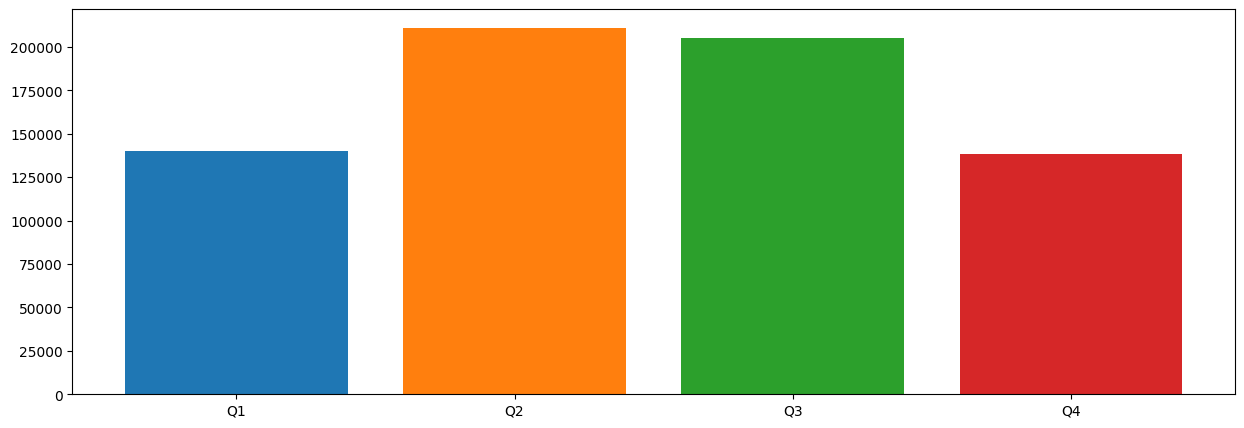

In [ ]:
grpd = data.groupby(['quarter'])[['item_count']].sum().squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.xticks(range(1,5),["Q"+str(i) for i in range(1,5)])
plt.show()

In [ ]:
data['year'] = data.date.dt.year

In [ ]:
data['quart-year'] = "Q" + data.quarter.astype(str) + "-" + data.year.astype(str)

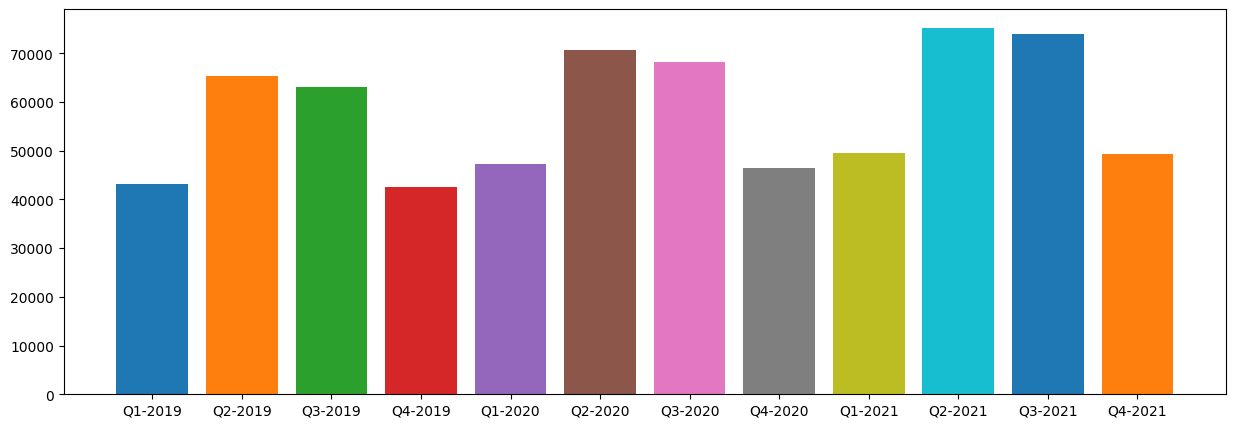

In [ ]:
order = ['Q{}-{}'.format(j,i) for i in range(2019, 2022) for j in range(1,5)]
grpd = data.groupby(["quart-year"])[['item_count']].sum()
grpd = grpd.loc[order].squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.show()

## Compare the performances of different restaurants.Which restaurant had the most sales? Also study the sales for each restaurant across different years months and days.


In [63]:
data.groupby('store_id')[['item_count']].sum()

item_count
store_id            
1           687527.0
2             1305.0
3             1736.0
4             1106.0
5             1310.0
6             1803.0

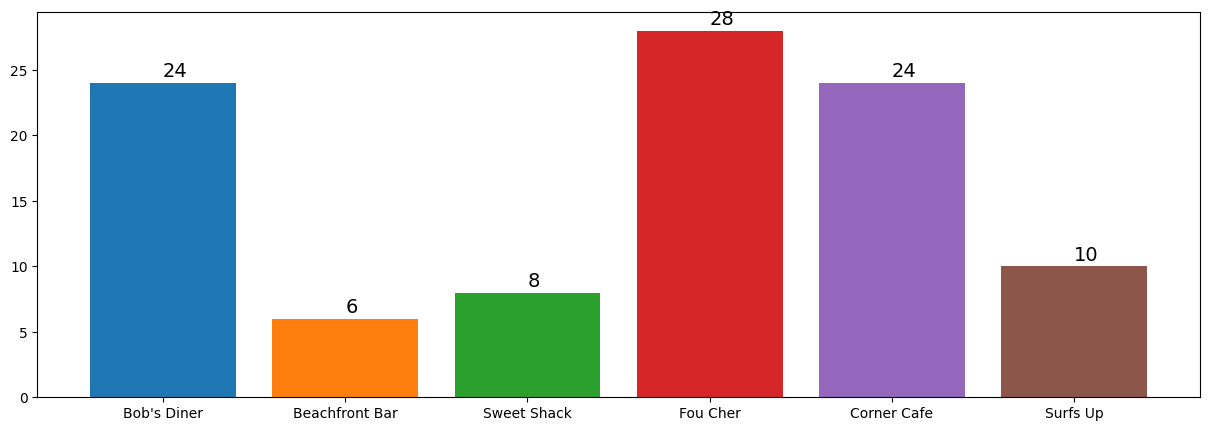

In [64]:
items_served = items.groupby(['store_id']).agg({'id' : "nunique"}).squeeze()
plt.figure(figsize = (15,5))
plt.bar(items_served.index, items_served.values, color = pal)
plt.xticks(range(1,7), restaurants.name)
for i in range(1,7):
  plt.annotate(items_served[i], xy = (i, items_served[i]+0.45), size = 14)

plt.show()

## store wise sales

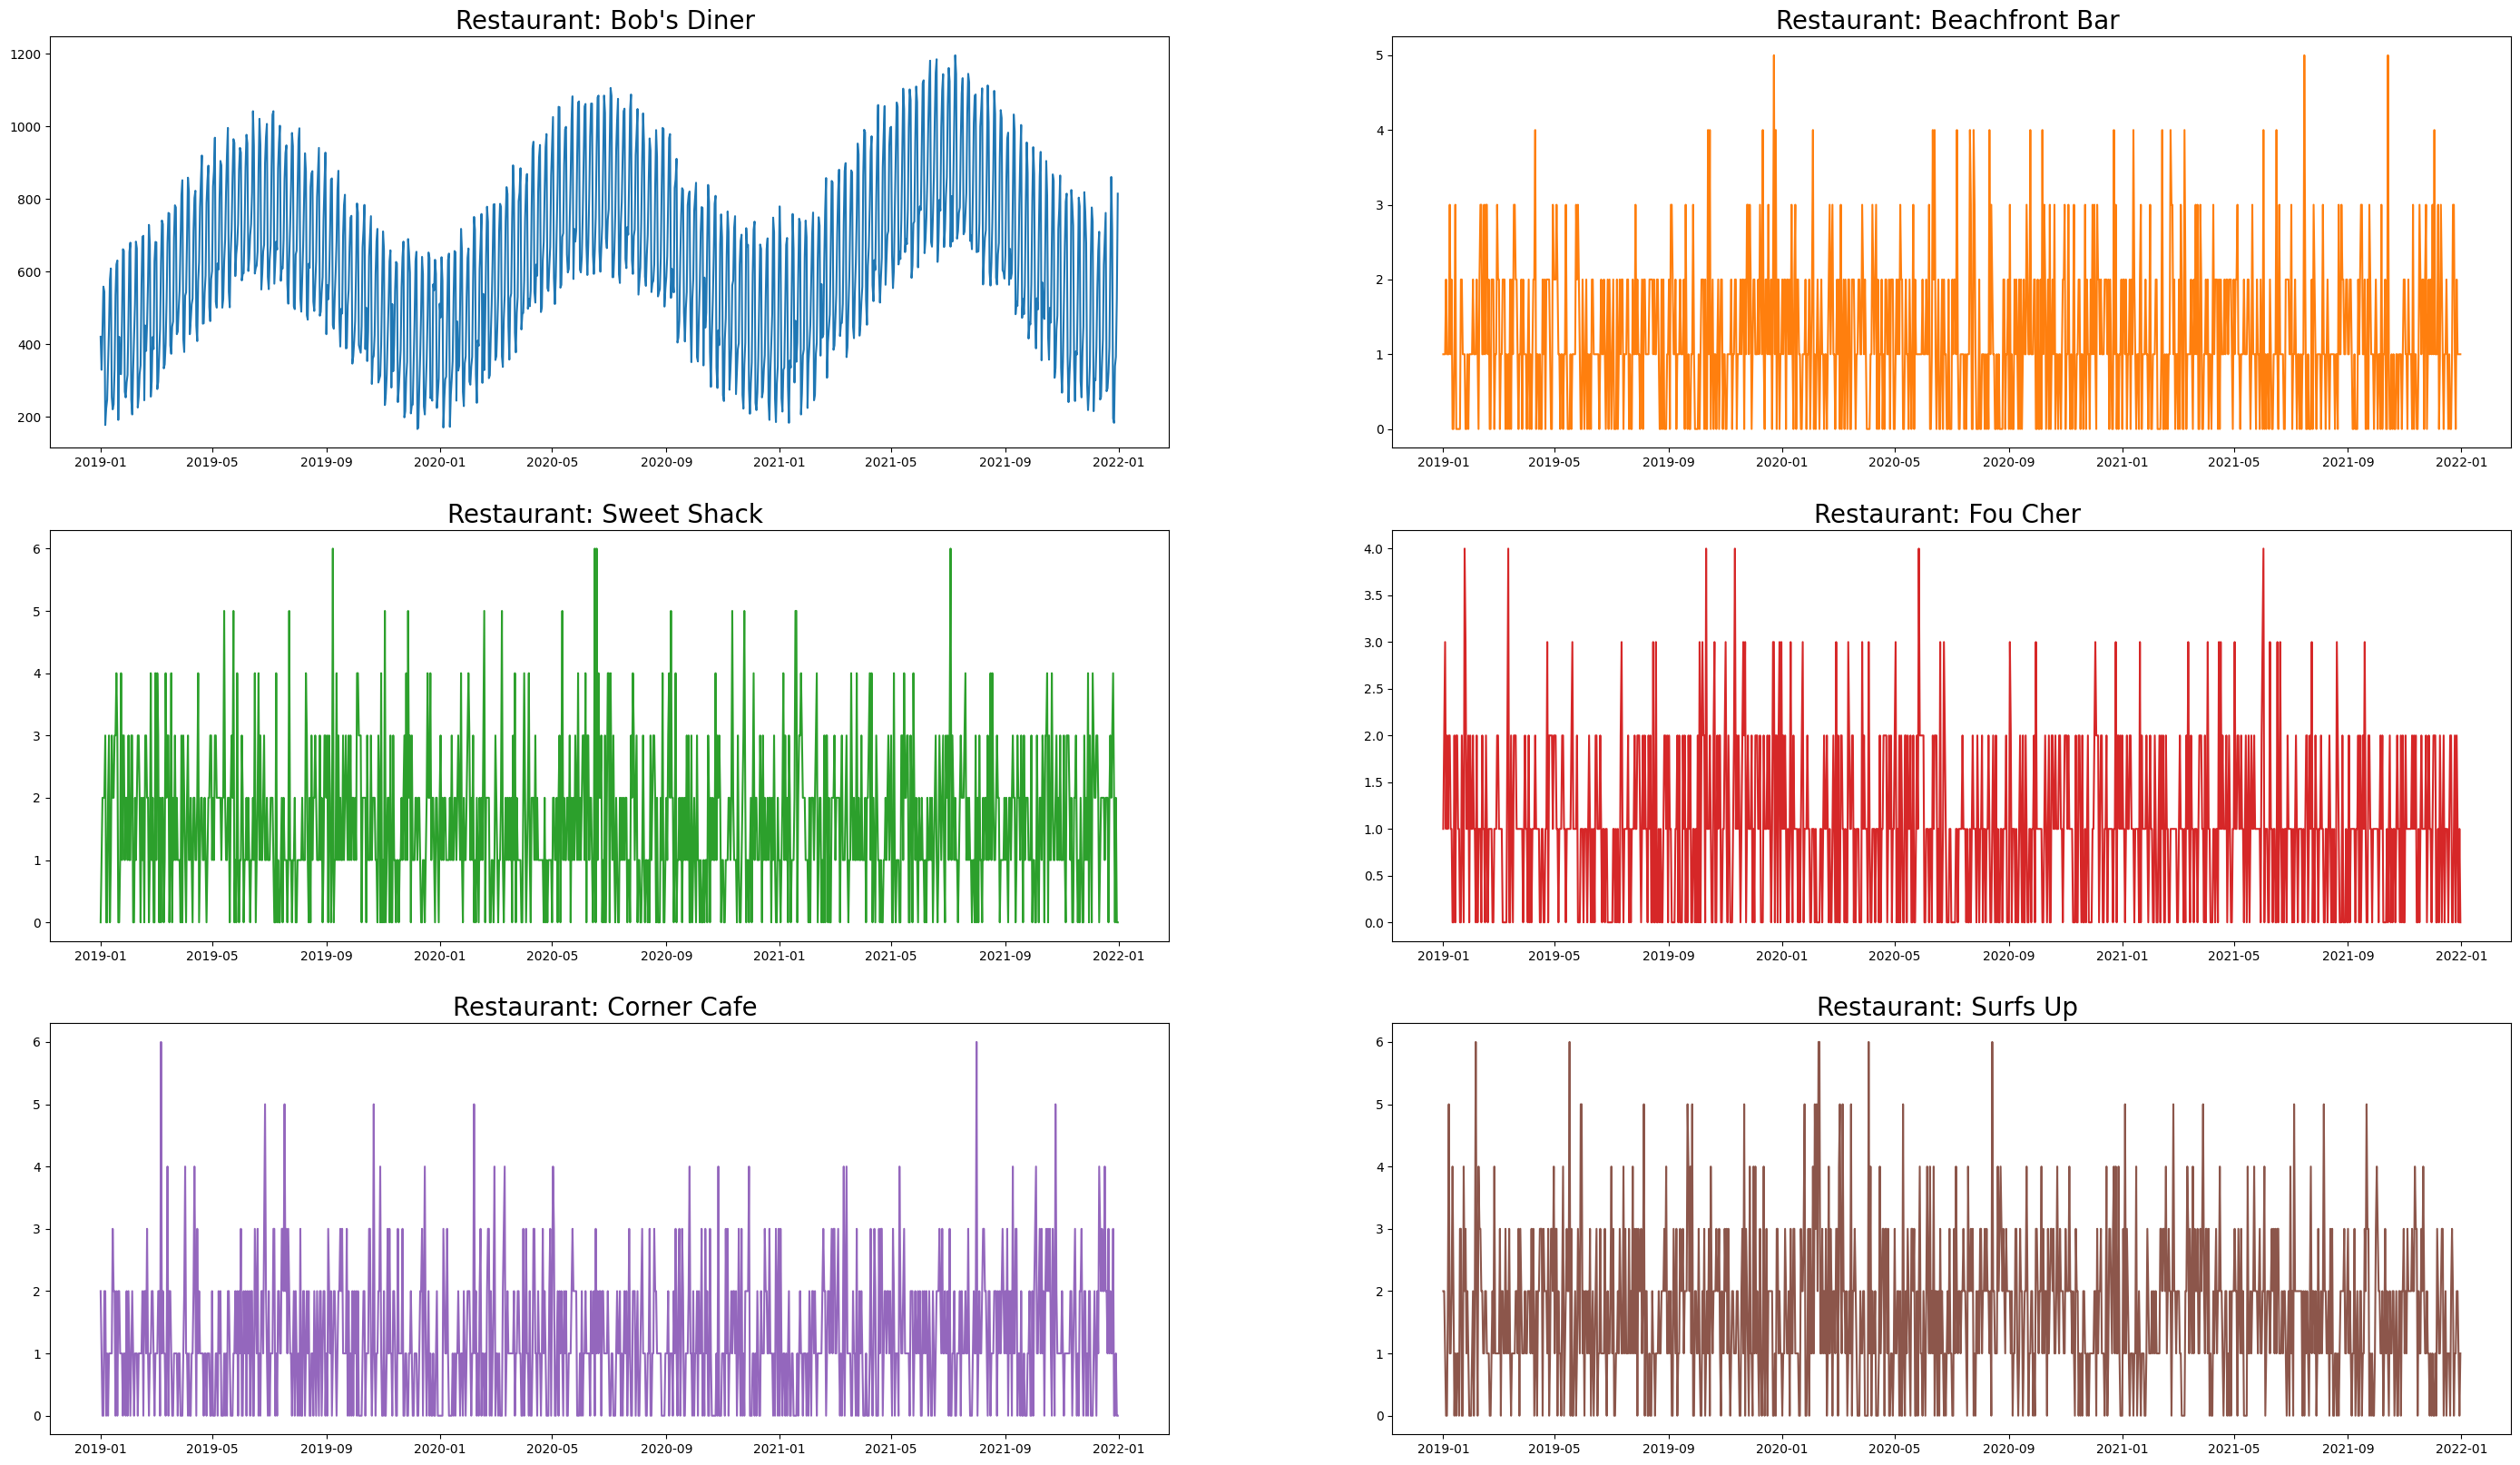

In [65]:
plot_data = data.pivot_table(index = 'date', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
f,ax = plt.subplots(3,2,figsize =(35,20) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].plot(plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('Restaurant: {} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1


# year wise sales for each store

In [ ]:
plot_data = data.pivot_table(index = 'quart-year', columns = 'store_id',values = 'item_count', aggfunc = 'sum')


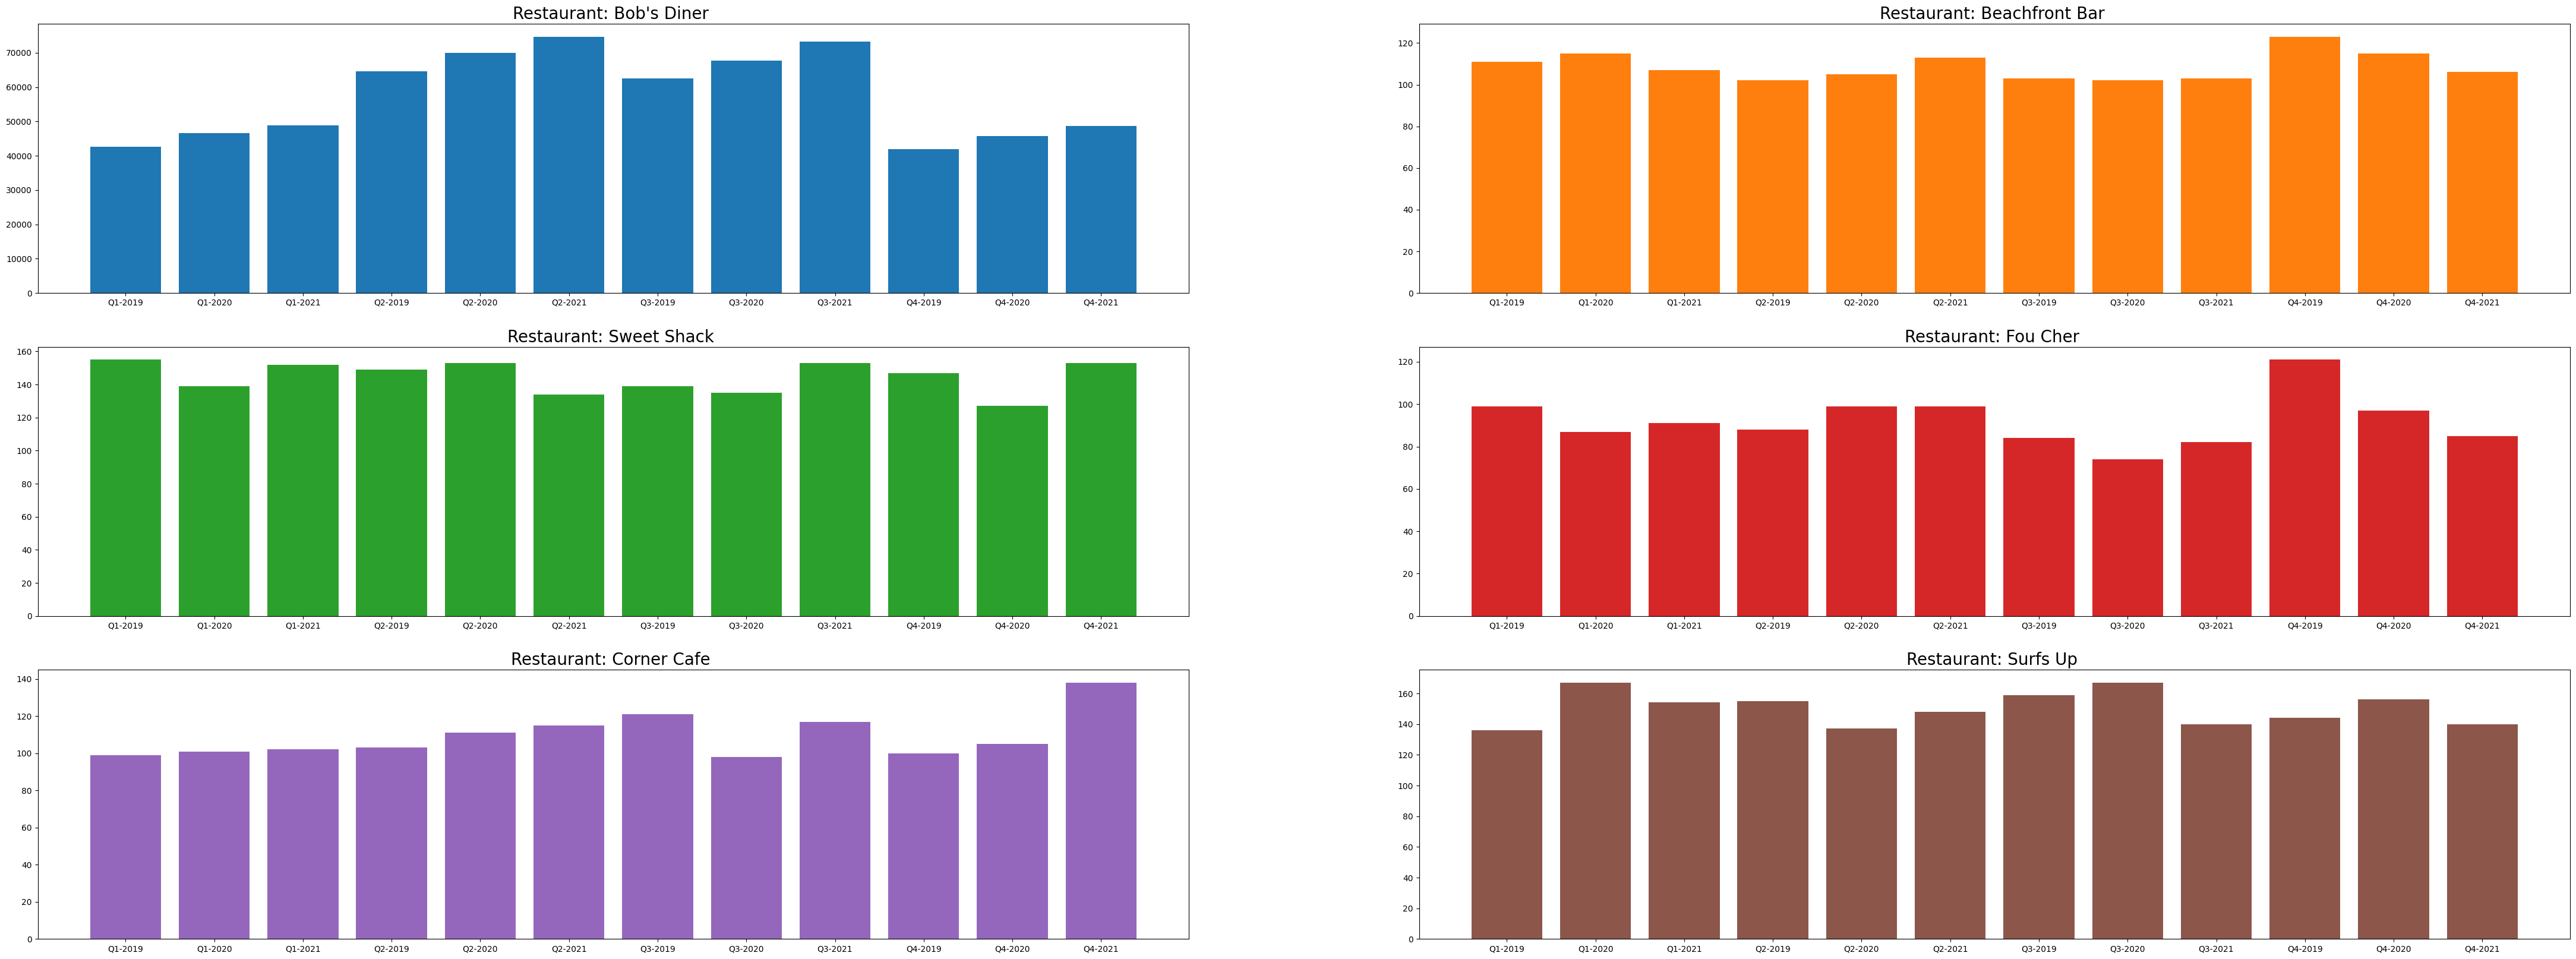

In [ ]:
plot_data = data.pivot_table(index = 'quart-year', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
f,ax = plt.subplots(3,2,figsize =(55,20) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].bar(x = plot_data.index,height = plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('Restaurant: {} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1


# Month wise sales

<ipython-input-38-fe7b83634bf2>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)


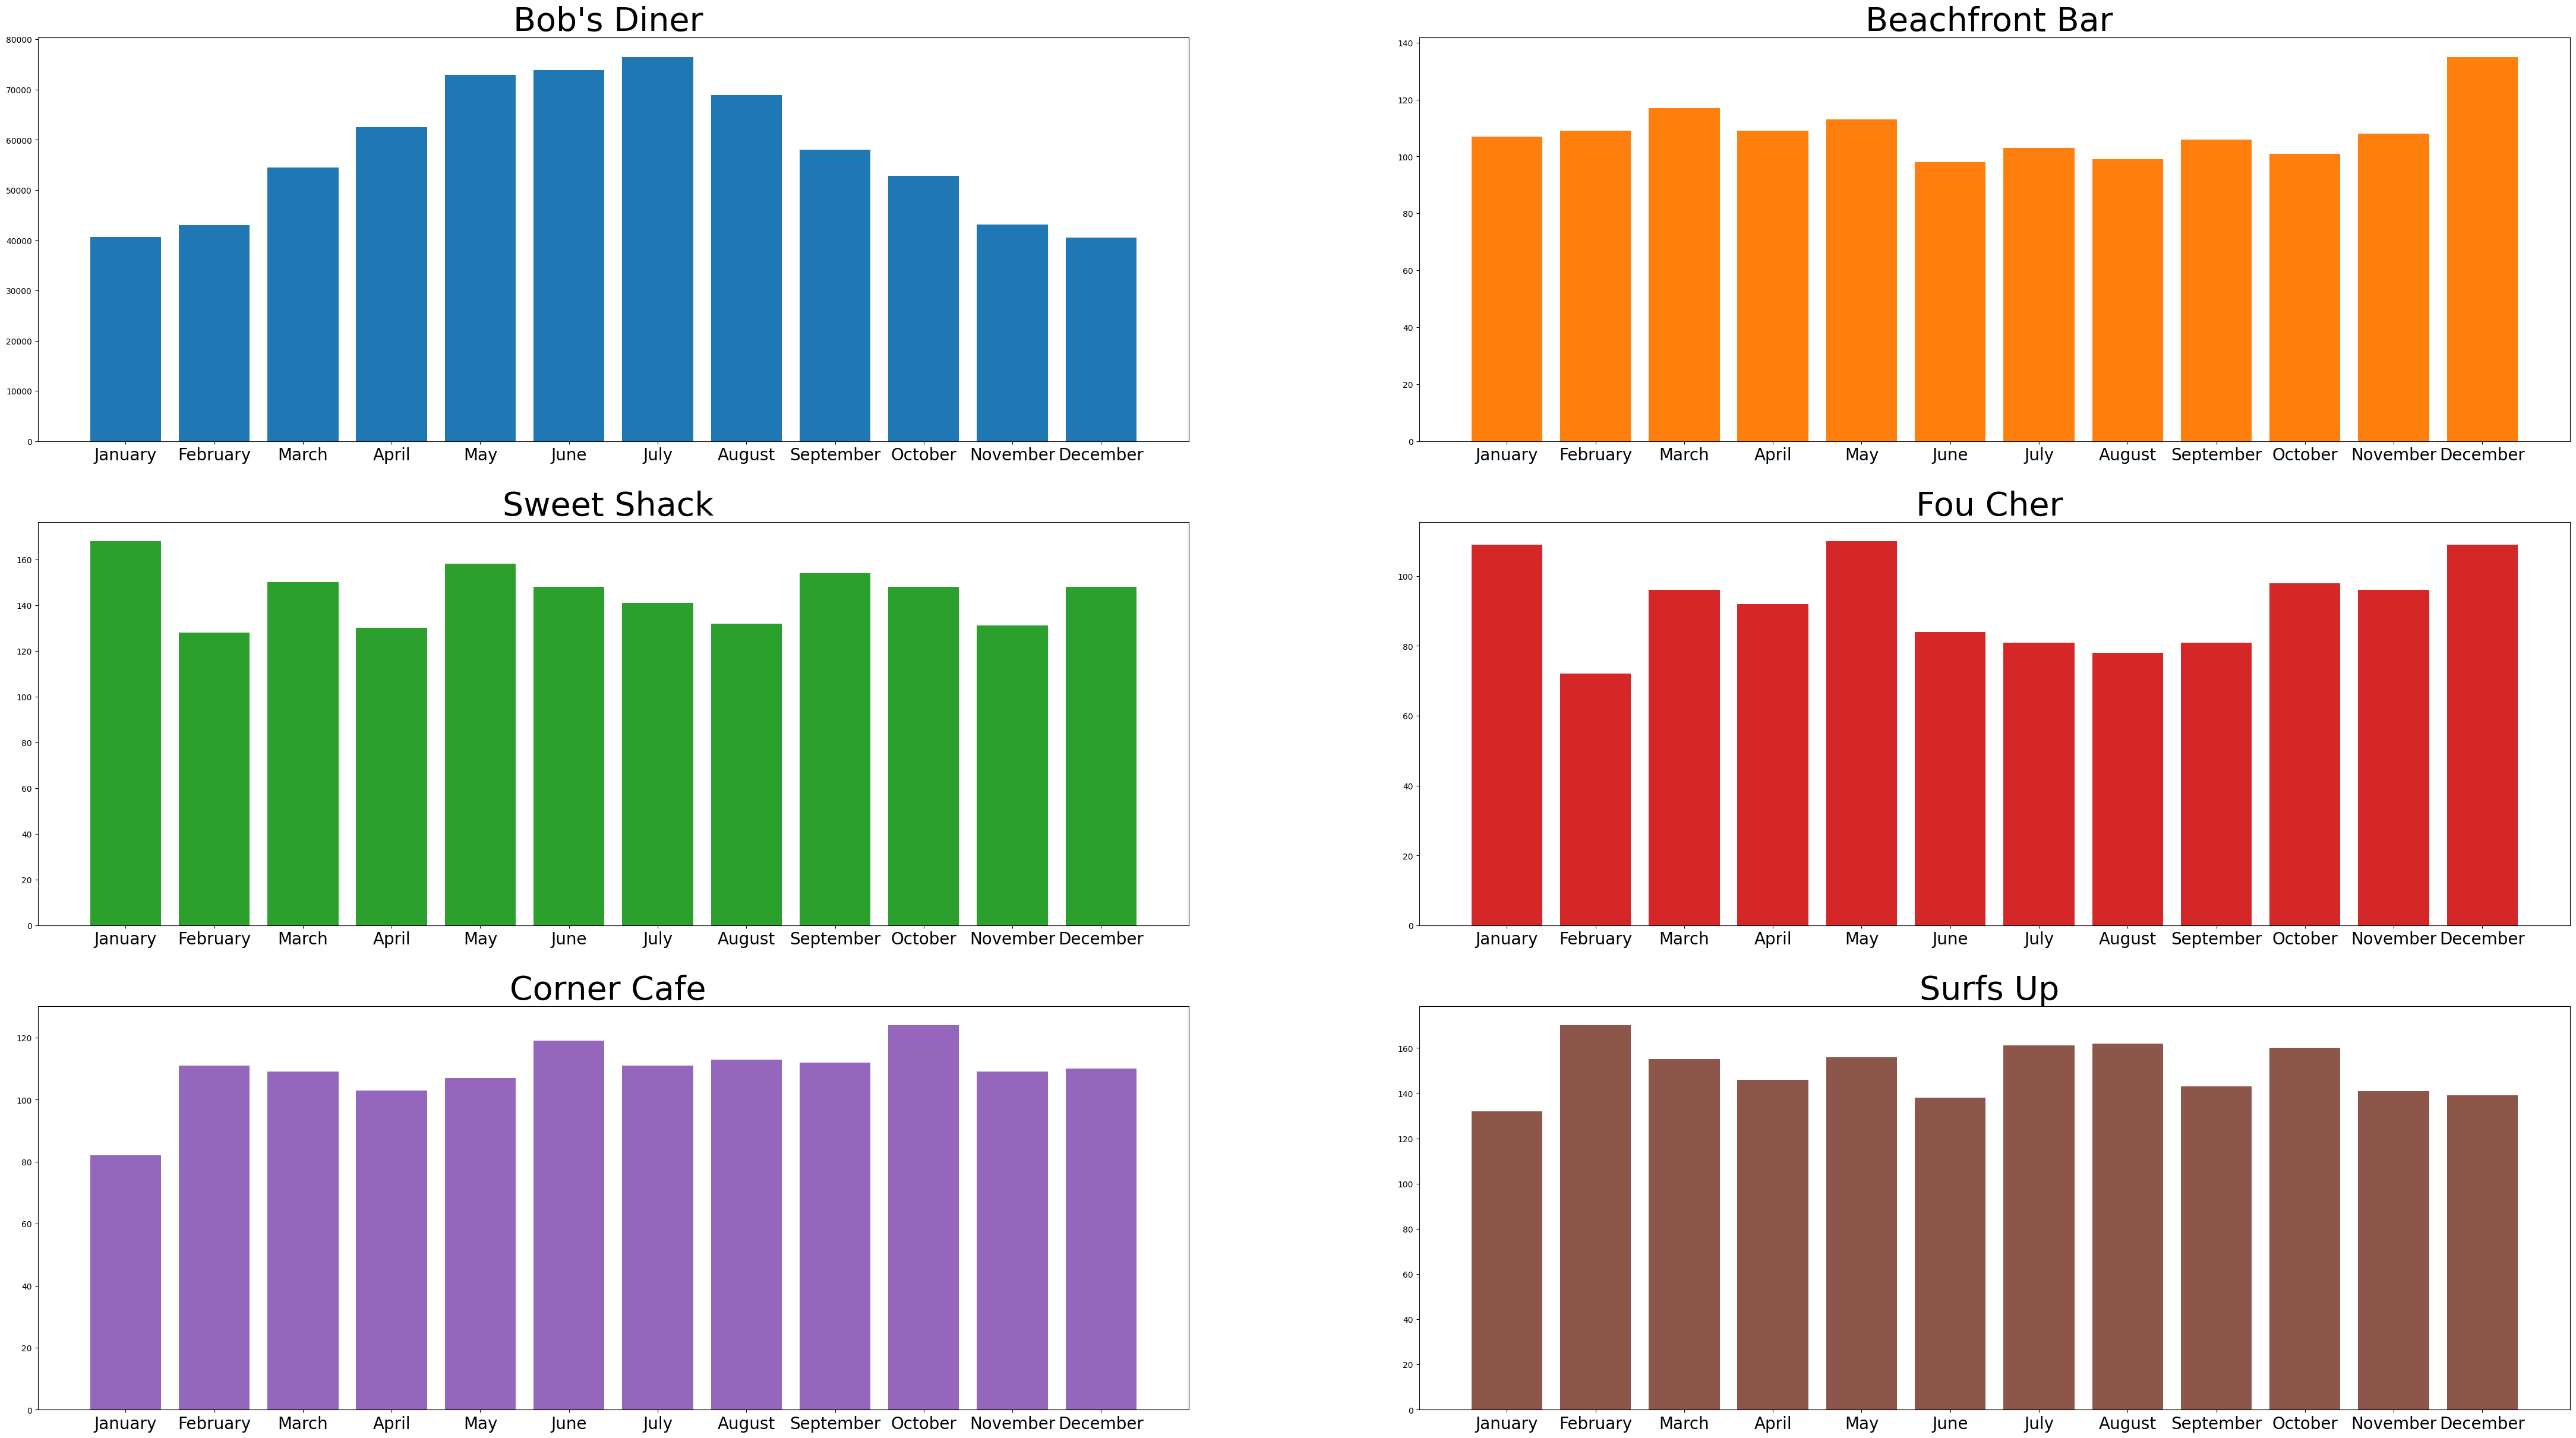

In [ ]:
plot_data = data.pivot_table(index = 'month_name', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
plot_data = plot_data.loc[months]
f,ax = plt.subplots(3,2,figsize =(55,30) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].bar(x = plot_data.index,height = plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('{} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 40)
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1

# Day wise sales

<ipython-input-39-2ca2e7a0d517>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)


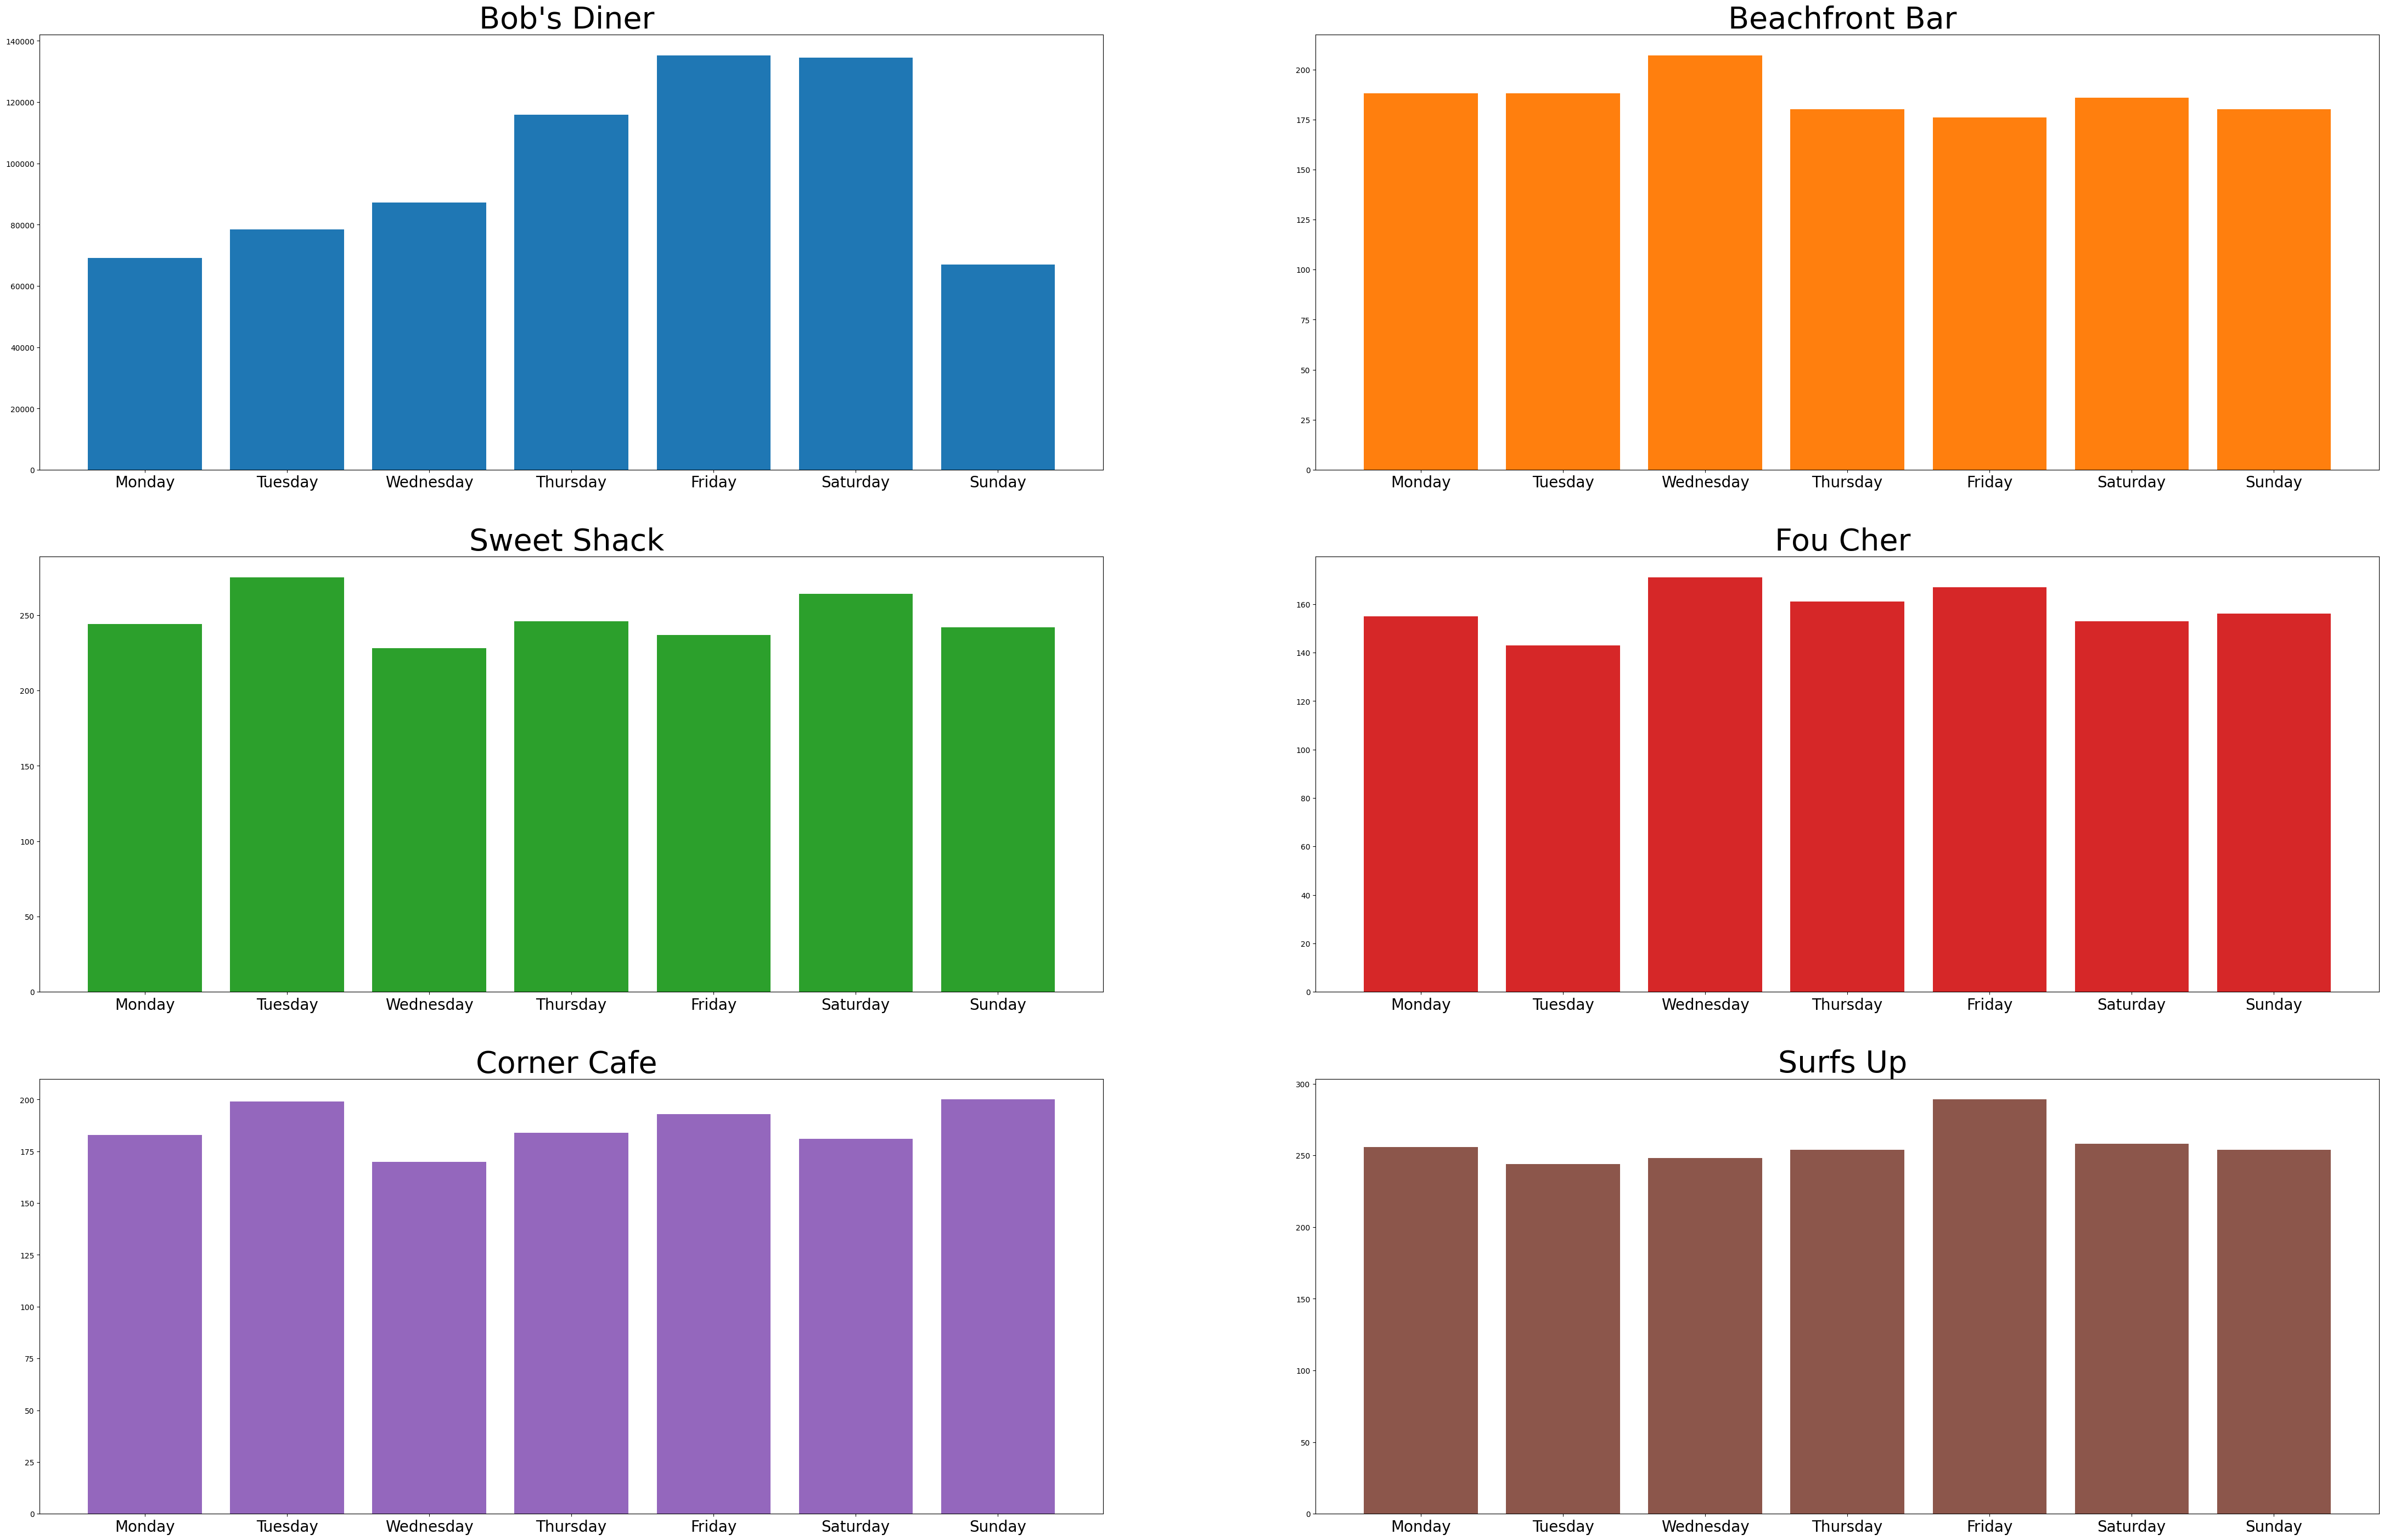

In [ ]:
plot_data = data.pivot_table(index = 'weekday', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
plot_data = plot_data.loc[day_names]
f,ax = plt.subplots(3,2,figsize =(55,35) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].bar(x = plot_data.index,height = plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('{} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 40)
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1
plt.show()

# Identify the most popular items overall and the stores where they are being sold. Also find out the most popular item at the store.


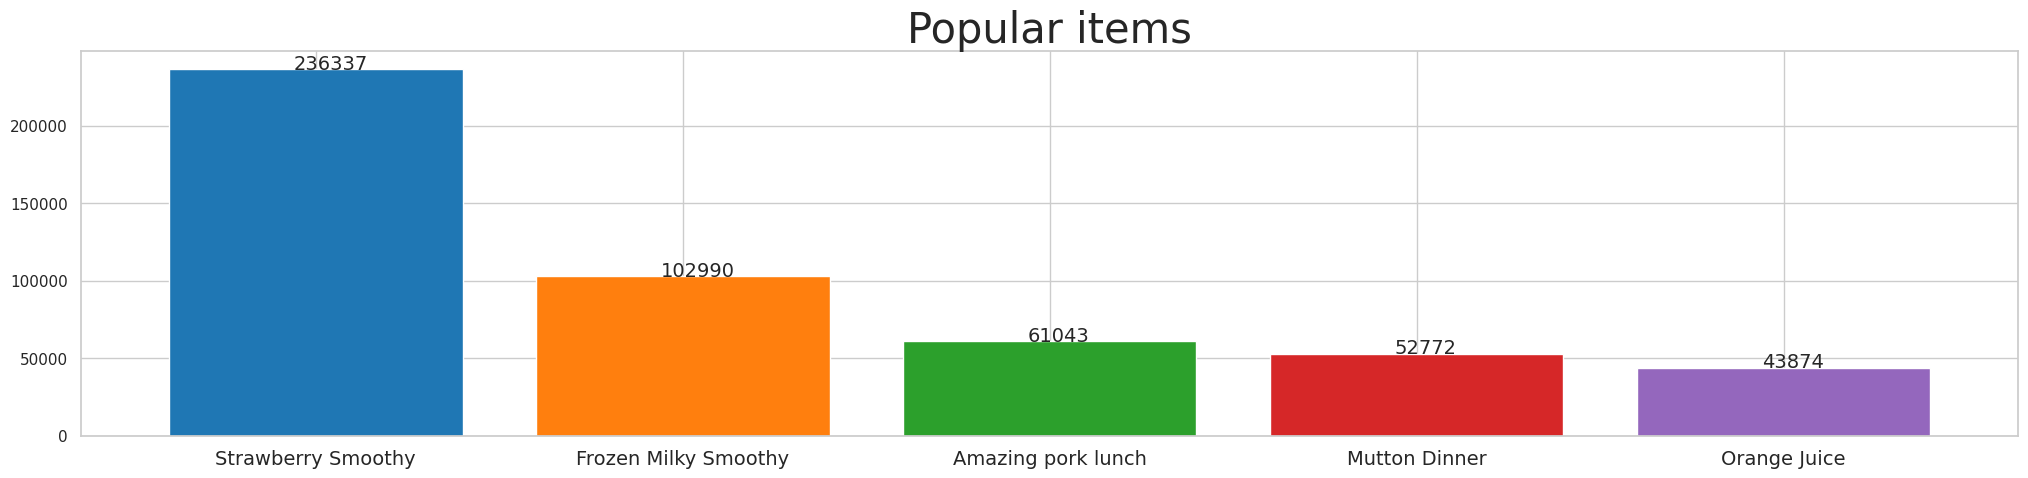

In [85]:
plot_data = data.groupby('item_id')[['item_count']].sum().sort_values('item_count',ascending = False).reset_index()[:5]
final_plot_data = pd.merge(plot_data, items, left_on = 'item_id', right_on = 'id', how = 'left')[['item_id', 'item_count', 'name', 'kcal', 'cost', 'store_id']]
plt.figure(figsize = (25,5))
plt.bar(final_plot_data.name, final_plot_data.item_count, color = pal_list)
plt.title('Popular items', size= 30)
for k in range(5):
  val = final_plot_data.loc[k,'item_count']
  plt.annotate('{:0.0f}'.format(val), xy = (k-0.06, val), size = 14)
plt.xticks(size = 14)
plt.show()

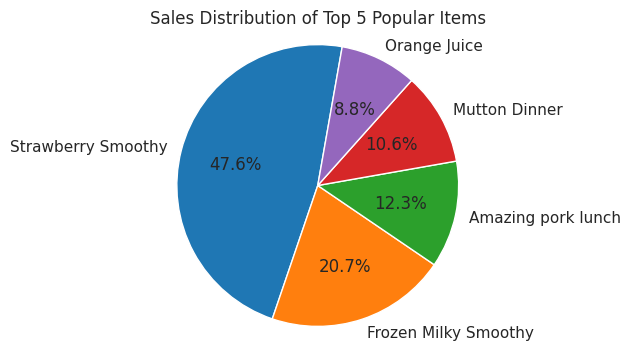

In [93]:
plt.figure(figsize=(4, 4))
plt.pie(final_plot_data.item_count, labels=final_plot_data.name, autopct='%1.1f%%', colors=pal_list, startangle=80)
plt.title('Sales Distribution of Top 5 Popular Items', size=12)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [94]:
count_data = data.pivot_table(index = 'item_id', columns = 'store_id',values = 'item_count', aggfunc = 'sum', fill_value = 0 )
item_ids = count_data.index[count_data.values.argmax(axis = 0)]


## Popular items restaurant wise

In [95]:
pop_items = items.loc[items.id.isin(item_ids), ['store_id', 'id', 'name', 'kcal', 'cost']]
pop_data = pd.merge(pop_items, restaurants, how = 'left', left_on = 'store_id', right_on = 'id', suffixes = ('_item', '_restaurant'))
pop_data['count'] = count_data.loc[item_ids,].sum(axis = 0).reset_index().iloc[:,1]
pop_data = pop_data[['name_restaurant', 'name_item', 'kcal', 'cost', 'count']]
pop_data

name_restaurant                      name_item  kcal   cost     count
0     Bob's Diner             Strawberry Smoothy   145   2.89  236337.0
1  Beachfront Bar        Fantastic Milky Smoothy   318   2.91    1147.0
2     Sweet Shack                Awesome Smoothy    78   1.39    1692.0
3     Corner Cafe           Frozen Milky Smoothy   211   3.98     298.0
4        Fou Cher  Blue Ribbon Fruity Vegi Lunch   881  53.98     273.0
5        Surfs Up             Awesome Soft Drink   248   3.06     997.0

# Determine if the store with the highest sales volume is also making the most money per day.


In [96]:
data.groupby('store_id')[['item_count']].sum().reset_index()

store_id  item_count
0         1    687527.0
1         2      1305.0
2         3      1736.0
3         4      1106.0
4         5      1310.0
5         6      1803.0

In [98]:
data

date  item_id  price  item_count  store_id  \
0      2019-01-01        3  29.22         2.0         1   
1      2019-01-01        4  26.42        22.0         1   
2      2019-01-01       12   4.87         7.0         1   
3      2019-01-01       13   4.18        12.0         1   
4      2019-01-01       16   3.21       136.0         1   
...           ...      ...    ...         ...       ...   
109595 2021-12-31       96  21.93         0.0         5   
109596 2021-12-31       97  28.65         0.0         4   
109597 2021-12-31       98   5.00         0.0         2   
109598 2021-12-31       99   5.32         0.0         4   
109599 2021-12-31      100   2.48         0.0         2   

                                                item_name  kcal  \
0                                       Sweet Fruity Cake   931   
1                         Amazing Steak Dinner with Rolls   763   
2                                    Fantastic Sweet Cola   478   
3                                 Sweet Frozen Soft Drink   490   
4                                    Frozen Milky Smoothy   284   
...                                                   ...   ...   
109595                  Blue Ribbon Fish with Bread Lunch   708   
109596  Original Fruity Cod with Bread and Vegetables ...   744   
109597                    Original Sweet Milky Soft Drink   579   
109598                           Frozen Tomato Soft Drink   423   
109599                             Awesome Vodka Cocktail   223   

       restaurant_name day_of_week  weekday  quarter  
0          Bob's Diner     Tuesday  Tuesday        1  
1          Bob's Diner     Tuesday  Tuesday        1  
2          Bob's Diner     Tuesday  Tuesday        1  
3          Bob's Diner     Tuesday  Tuesday        1  
4          Bob's Diner     Tuesday  Tuesday        1  
...                ...         ...      ...      ...  
109595     Corner Cafe      Friday   Friday        4  
109596        Fou Cher      Friday   Friday        4  
109597  Beachfront Bar      Friday   Friday        4  
109598        Fou Cher      Friday   Friday        4  
109599  Beachfront Bar      Friday   Friday        4  

[109600 rows x 11 columns]

In [99]:
data['year'] = data.date.dt.year

In [100]:
data.pivot_table(index = 'store_id', columns = 'year', values = 'item_count', aggfunc = 'sum')

year          2019      2020      2021
store_id                              
1         211799.0  230191.0  245537.0
2            439.0     437.0     429.0
3            590.0     554.0     592.0
4            392.0     357.0     357.0
5            423.0     415.0     472.0
6            594.0     627.0     582.0

In [101]:
data['sales_amnt'] = data.item_count * data.price

In [102]:
data.pivot_table(index = 'store_id', columns = 'year', values = 'sales_amnt', aggfunc = 'sum')

year            2019        2020        2021
store_id                                    
1         1849483.49  2112331.91  2375460.29
2            1281.85     1267.21     1247.14
3             872.59      828.65      877.03
4            9698.80     8590.87     9595.70
5            5292.93     5347.71     5910.79
6            5132.65     5314.43     5204.41

In [103]:
count_order = data.pivot_table(index = 'store_id',  values = 'sales_amnt', aggfunc = 'sum').squeeze()
count_order_rest = count_order.sort_values(ascending = False).index

In [104]:
sales_order = data.pivot_table(index = 'store_id',  values = 'item_count', aggfunc = 'sum').squeeze()
sales_order_rest = sales_order.sort_values(ascending = False).index

In [105]:
restaurants

id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe
5   6        Surfs Up

## since restaurant id 1 i.e Bob's Diner has disproportionate data we will leave it out for this analysis to understand that number and sales values match or not for others or not

In [106]:
count_order

store_id
1    6337275.69
2       3796.20
3       2578.27
4      27885.37
5      16551.43
6      15651.49
Name: sales_amnt, dtype: float64

In [107]:
restaurants.set_index('id').loc[count_order_rest]

name
store_id                
1            Bob's Diner
4               Fou Cher
5            Corner Cafe
6               Surfs Up
2         Beachfront Bar
3            Sweet Shack

In [108]:
restaurants.set_index('id').loc[sales_order_rest]

name
store_id                
1            Bob's Diner
6               Surfs Up
3            Sweet Shack
5            Corner Cafe
2         Beachfront Bar
4               Fou Cher

## Bob's Diner is highest grossing in numbers as well as sales value.
## However Fou Cher which is second highest with respect to numbers on the other hand its making least money out of the 6 restaurants

# Identify the most expensive item at each restaurant and find out its calorie count.

In [ ]:
items.iloc[[items.cost.argmax()]]

id  store_id                           name  kcal   cost
79  80         4  Blue Ribbon Fruity Vegi Lunch   881  53.98

In [ ]:
items.sort_values("cost",ascending = False)[:5]

id  store_id                                               name  kcal  \
79  80         4                      Blue Ribbon Fruity Vegi Lunch   881   
2    3         1                                  Sweet Fruity Cake   931   
55  56         1                    Sea Bass with Vegetables Dinner   613   
96  97         4  Original Fruity Cod with Bread and Vegetables ...   744   
33  34         4                                  Sweet Savory Cake   721   

     cost  
79  53.98  
2   29.22  
55  28.75  
96  28.65  
33  27.47

##  max and min cost of items sold at each restaurant

In [ ]:
items.groupby('store_id')[['cost']].agg(['max', 'min', 'mean'])

cost                 
            max   min       mean
store_id                        
1         29.22  2.89  12.211667
2          5.70  2.43   3.585000
3          7.70  1.39   5.276250
4         53.98  3.23  12.819643
5         26.37  3.74  13.371667
6         26.21  3.06  13.970000

## Develop a linear regression, random forest and XGBoost model to predict for the model with the given data. Compare and comment on the results obtained.
- Create required features for development of these models like day of the week, quarter of the year, month, year, day of the month etc.
- Use the last six months data as test data.
- Compute the RMSE values for each of the models to compare their performances.
- Also use these models to forecast for 1 year.


In [109]:
data.date.describe()

count                 109600
mean     2020-07-01 12:00:00
min      2019-01-01 00:00:00
25%      2019-10-01 18:00:00
50%      2020-07-01 12:00:00
75%      2021-04-01 06:00:00
max      2021-12-31 00:00:00
Name: date, dtype: object

In [110]:
ts = data.groupby('date')[['item_count']].sum().squeeze()


In [112]:
data.head()

date  item_id  price  item_count  store_id  \
0 2019-01-01        3  29.22         2.0         1   
1 2019-01-01        4  26.42        22.0         1   
2 2019-01-01       12   4.87         7.0         1   
3 2019-01-01       13   4.18        12.0         1   
4 2019-01-01       16   3.21       136.0         1   

                         item_name  kcal restaurant_name day_of_week  weekday  \
0                Sweet Fruity Cake   931     Bob's Diner     Tuesday  Tuesday   
1  Amazing Steak Dinner with Rolls   763     Bob's Diner     Tuesday  Tuesday   
2             Fantastic Sweet Cola   478     Bob's Diner     Tuesday  Tuesday   
3          Sweet Frozen Soft Drink   490     Bob's Diner     Tuesday  Tuesday   
4             Frozen Milky Smoothy   284     Bob's Diner     Tuesday  Tuesday   

   quarter  year  sales_amnt  
0        1  2019       58.44  
1        1  2019      581.24  
2        1  2019       34.09  
3        1  2019       50.16  
4        1  2019      436.56

In [116]:
time_series = data.groupby(['date']).agg({'item_count':'sum', 'weekday': lambda x :x.unique()[0],
                            'quarter' : lambda x :x.unique()[0], 'year': lambda x :x.unique()[0],
                            'month_name' : lambda x :x.unique()[0],
                            'year':lambda x :x.unique()[0]})

# adding some more features : day of the year, day of the month and week of the year

In [117]:
time_series['day_year'] = time_series.index.day_of_year
time_series['day_month'] = time_series.index.day
time_series['week_num'] = time_series.index.isocalendar().week.astype(int)
time_series

item_count    weekday  quarter  year month_name  day_year  \
date                                                                    
2019-01-01       427.0    Tuesday        1  2019    January         1   
2019-01-02       337.0  Wednesday        1  2019    January         2   
2019-01-03       445.0   Thursday        1  2019    January         3   
2019-01-04       564.0     Friday        1  2019    January         4   
2019-01-05       552.0   Saturday        1  2019    January         5   
...                ...        ...      ...   ...        ...       ...   
2021-12-27       192.0     Monday        4  2021   December       361   
2021-12-28       344.0    Tuesday        4  2021   December       362   
2021-12-29       371.0  Wednesday        4  2021   December       363   
2021-12-30       527.0   Thursday        4  2021   December       364   
2021-12-31       817.0     Friday        4  2021   December       365   

            day_month  week_num  
date                             
2019-01-01          1         1  
2019-01-02          2         1  
2019-01-03          3         1  
2019-01-04          4         1  
2019-01-05          5         1  
...               ...       ...  
2021-12-27         27        52  
2021-12-28         28        52  
2021-12-29         29        52  
2021-12-30         30        52  
2021-12-31         31        52  

[1096 rows x 8 columns]

## convert the categorical to numeric using ordinal encoder as here data is ordered in terms of weekday and month name

In [118]:
from sklearn.preprocessing import OrdinalEncoder

In [119]:
day_names

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [120]:
ord_enc = OrdinalEncoder(categories = [months, day_names])
ord_enc.fit(time_series[['month_name', 'weekday']])
time_series[['month_name', 'weekday']] = ord_enc.transform(time_series[['month_name', 'weekday']])

In [121]:
time_series

item_count  weekday  quarter  year  month_name  day_year  \
date                                                                   
2019-01-01       427.0      1.0        1  2019         0.0         1   
2019-01-02       337.0      2.0        1  2019         0.0         2   
2019-01-03       445.0      3.0        1  2019         0.0         3   
2019-01-04       564.0      4.0        1  2019         0.0         4   
2019-01-05       552.0      5.0        1  2019         0.0         5   
...                ...      ...      ...   ...         ...       ...   
2021-12-27       192.0      0.0        4  2021        11.0       361   
2021-12-28       344.0      1.0        4  2021        11.0       362   
2021-12-29       371.0      2.0        4  2021        11.0       363   
2021-12-30       527.0      3.0        4  2021        11.0       364   
2021-12-31       817.0      4.0        4  2021        11.0       365   

            day_month  week_num  
date                             
2019-01-01          1         1  
2019-01-02          2         1  
2019-01-03          3         1  
2019-01-04          4         1  
2019-01-05          5         1  
...               ...       ...  
2021-12-27         27        52  
2021-12-28         28        52  
2021-12-29         29        52  
2021-12-30         30        52  
2021-12-31         31        52  

[1096 rows x 8 columns]

## Generate Test Data

In [122]:
train = time_series[time_series.index < '2021-07-01']
test = time_series[time_series.index >= '2021-07-01']

In [123]:
y_var = 'item_count'
x_vars = time_series.drop(columns = 'item_count').columns

In [124]:
X_train = train[x_vars]
Y_train = train[y_var]
X_test = test[x_vars]
Y_test = test[y_var]

## Linear Regression

In [125]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [126]:
test['lr_pred'] = lr.predict(X_test)

<ipython-input-126-56b7e049463a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lr_pred'] = lr.predict(X_test)


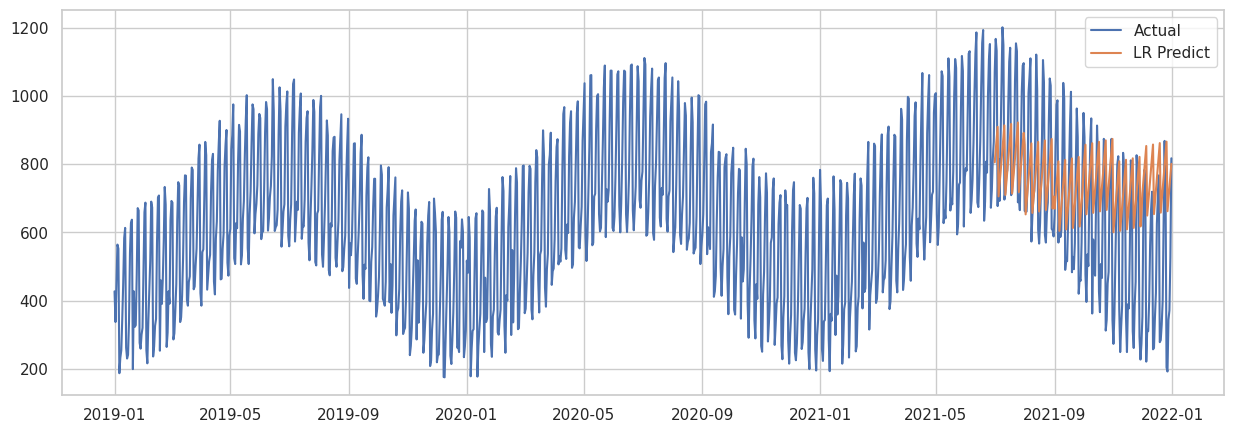

In [127]:
plt.figure(figsize = (15,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.lr_pred, label = "LR Predict")
plt.legend()
plt.show()

In [128]:
lr_rmse = mean_squared_error(y_true = test.item_count, y_pred = test.lr_pred, squared = False)
lr_mae = mean_absolute_error(y_true = test.item_count, y_pred = test.lr_pred)
lr_r2_score = r2_score(y_true = test.item_count, y_pred = test.lr_pred)
print("Linear Regression :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(lr_rmse,lr_mae,lr_r2_score*100))

Linear Regression :
RMSE : 244.21
MAE : 196.04
R2_Score : 7.65


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [129]:
results = pd.DataFrame([lr_rmse, lr_mae,lr_r2_score*100], index = ['RMSE', 'MAE', 'R2_Score'], columns = ['Linear Regression']).round(2)
results

Linear Regression
RMSE                 244.21
MAE                  196.04
R2_Score               7.65

# Random Forest

In [130]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20)

In [131]:
test['rf_pred'] = rf.predict(X_test)

<ipython-input-131-d81d7ce4fb67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rf_pred'] = rf.predict(X_test)


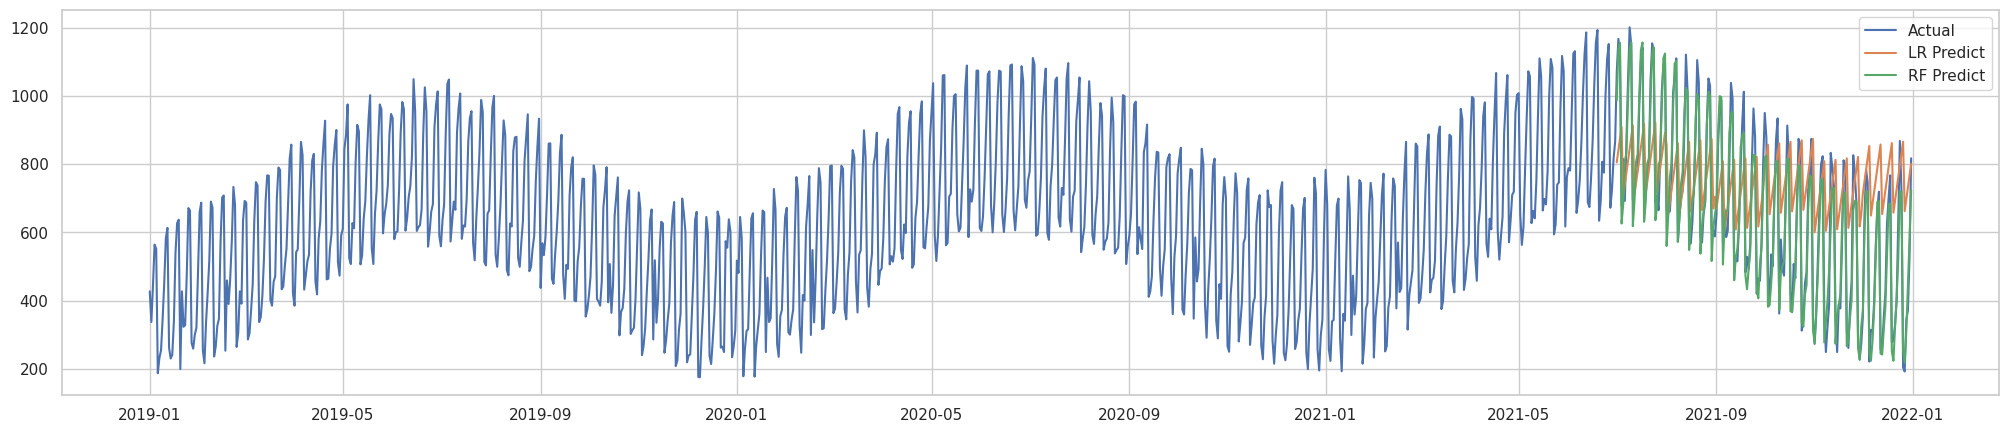

In [132]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.lr_pred, label = "LR Predict")
plt.plot(test.rf_pred, label = "RF Predict")
plt.legend()
plt.show()

In [133]:
rf_rmse = mean_squared_error(y_true = test.item_count, y_pred = test.rf_pred, squared = False)
rf_mae = mean_absolute_error(y_true = test.item_count, y_pred = test.rf_pred)
rf_r2_score = r2_score(y_true = test.item_count, y_pred = test.rf_pred)
print("Random Forest Regression :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(rf_rmse,rf_mae,rf_r2_score*100))

Random Forest Regression :
RMSE : 61.11
MAE : 48.48
R2_Score : 94.22


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [134]:
results['Random Forest'] = [rf_rmse,rf_mae,rf_r2_score*100]
results.round(2)

Linear Regression  Random Forest
RMSE                 244.21          61.11
MAE                  196.04          48.48
R2_Score               7.65          94.22

## XGBoost

In [135]:
xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
xgb.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[0]	validation_0-rmse:660.07829	validation_1-rmse:709.01212
[100]	validation_0-rmse:262.51190	validation_1-rmse:311.53220
[200]	validation_0-rmse:121.36888	validation_1-rmse:171.11193


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:26:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:71.72975	validation_1-rmse:105.03640
[400]	validation_0-rmse:52.50055	validation_1-rmse:78.37923
[500]	validation_0-rmse:44.19461	validation_1-rmse:71.59216
[590]	validation_0-rmse:40.38314	validation_1-rmse:71.95490


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

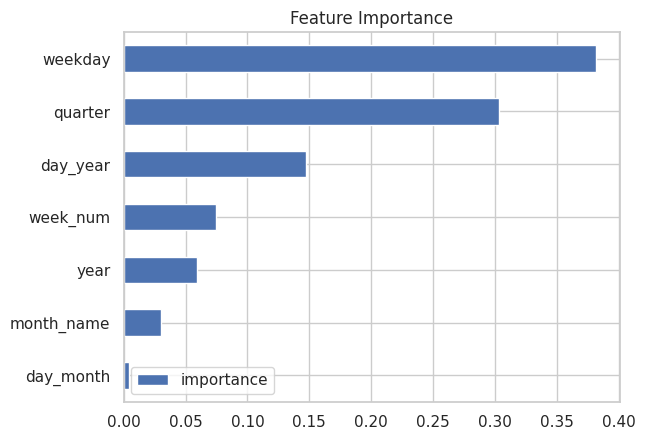

In [136]:
importance = pd.DataFrame(data=xgb.feature_importances_,
             index=xgb.get_booster().feature_names,
             columns=['importance'])
importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [137]:
test['xgb_pred'] = xgb.predict(X_test)

<ipython-input-137-03d1de6ce658>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['xgb_pred'] = xgb.predict(X_test)


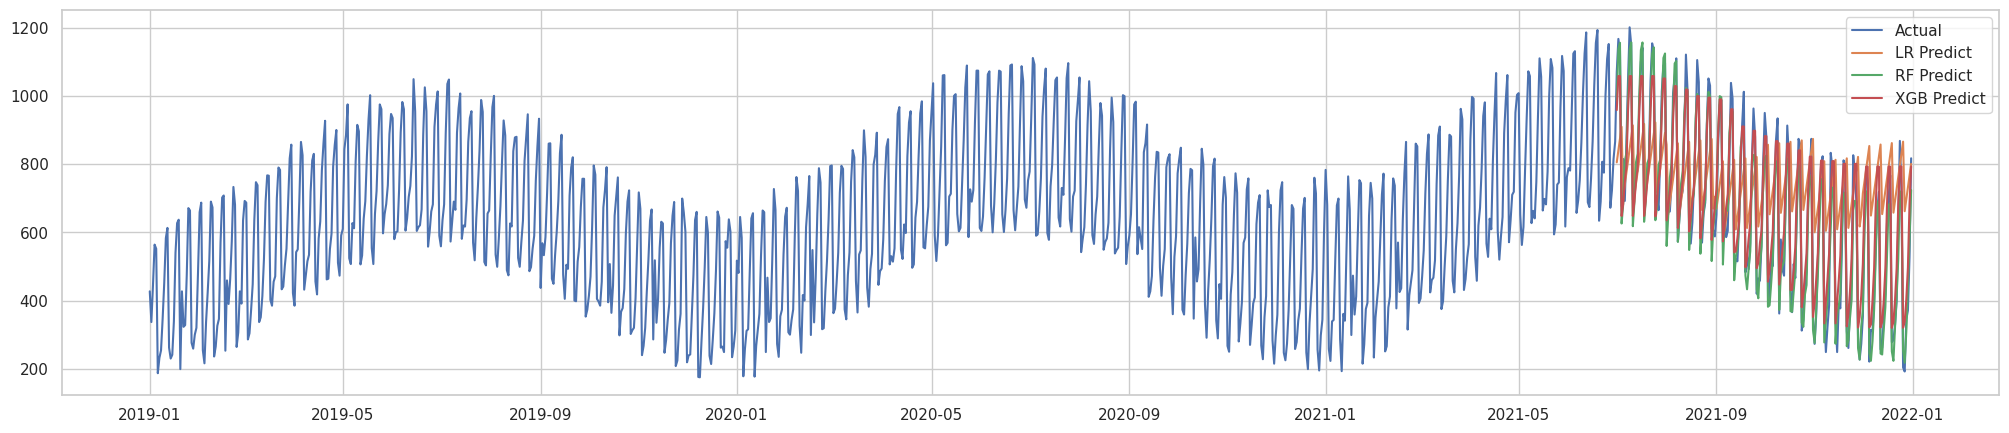

In [138]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.lr_pred, label = "LR Predict")
plt.plot(test.rf_pred, label = "RF Predict")
plt.plot(test.xgb_pred, label = "XGB Predict")
plt.legend()
plt.show()

In [139]:
xgb_rmse = mean_squared_error(y_true = test.item_count, y_pred = test.xgb_pred, squared = False)
xgb_mae = mean_absolute_error(y_true = test.item_count, y_pred = test.xgb_pred)
xgb_r2_score = r2_score(y_true = test.item_count, y_pred = test.xgb_pred)
print("XGBoost :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(xgb_rmse,xgb_mae,xgb_r2_score*100))

XGBoost :
RMSE : 71.18
MAE : 58.45
R2_Score : 92.15


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [140]:
results['XGBoost'] = [xgb_rmse,xgb_mae,xgb_r2_score*100]
results = results.round(2)

In [ ]:
results

Linear Regression  Random Forest  XGBoost
RMSE                 244.21          59.06    71.18
MAE                  196.04          47.02    58.45
R2_Score               7.65          94.60    92.15

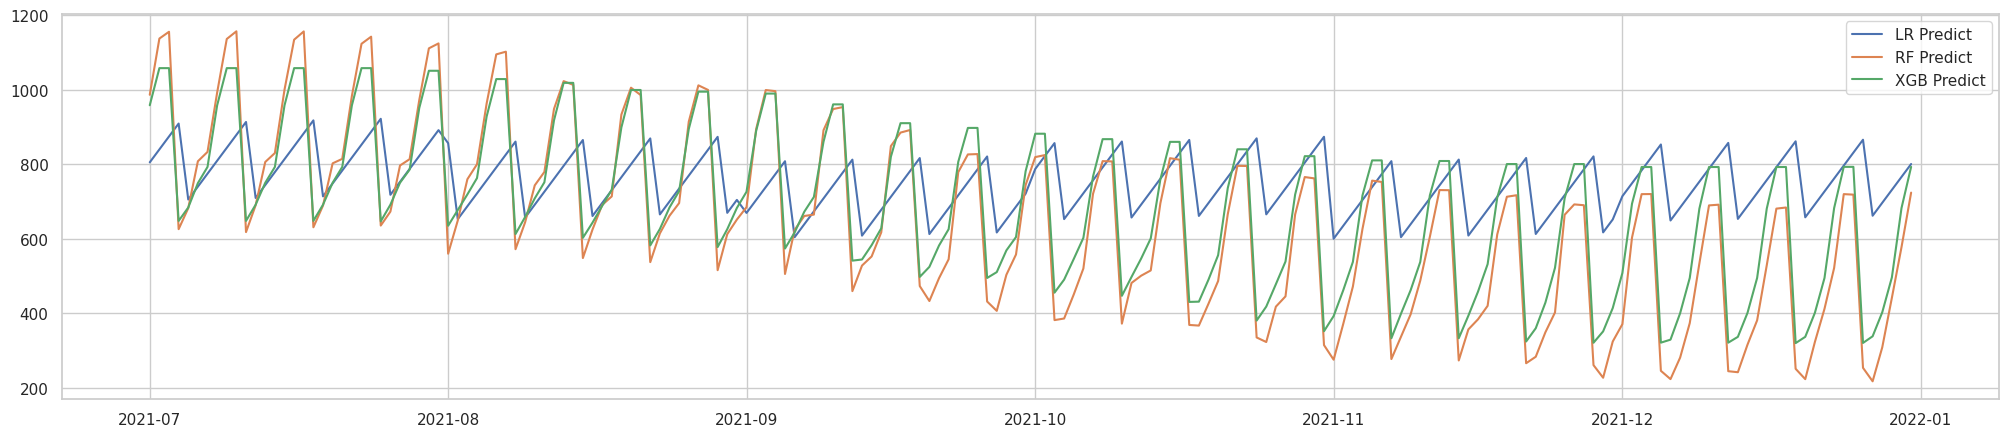

In [141]:
plt.figure(figsize = (25,5))
plt.plot(test.lr_pred, label = "LR Predict")
plt.plot(test.rf_pred, label = "RF Predict")
plt.plot(test.xgb_pred, label = "XGB Predict")
plt.legend()
plt.show()

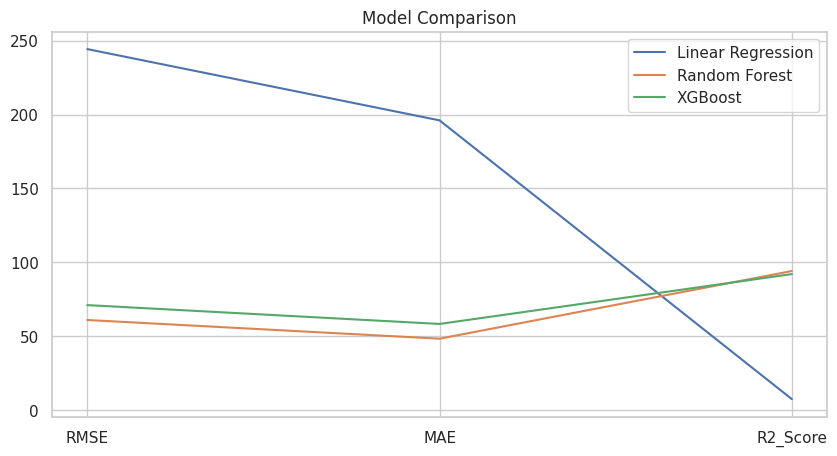

In [142]:
plt.figure(figsize = (10,5))
plt.plot(results['Linear Regression'], label = "Linear Regression")
plt.plot(results['Random Forest'], label = "Random Forest")
plt.plot(results['XGBoost'], label = "XGBoost")
plt.legend(loc = "upper right")
plt.title("Model Comparison")
plt.show()


In [143]:
results

Linear Regression  Random Forest  XGBoost
RMSE                 244.21          61.11    71.18
MAE                  196.04          48.48    58.45
R2_Score               7.65          94.22    92.15

## the best model here is RF : using it for predictions

In [ ]:
time_series.index.max()

Timestamp('2021-12-31 00:00:00')

In [ ]:
future_predictors = pd.DataFrame(pd.date_range(start="2022-01-01", end="2022-12-31"), columns=['date'])
future_predictors.index = pd.to_datetime(future_predictors.date)


In [ ]:
X_train.columns

Index(['weekday', 'quarter', 'year', 'month_name', 'day_year', 'day_month',
       'week_num'],
      dtype='object')

In [ ]:
future_predictors.date.dt.isocalendar().week

date
2022-01-01    52
2022-01-02    52
2022-01-03     1
2022-01-04     1
2022-01-05     1
              ..
2022-12-27    52
2022-12-28    52
2022-12-29    52
2022-12-30    52
2022-12-31    52
Name: week, Length: 365, dtype: UInt32

In [ ]:
future_predictors['weekday'] = future_predictors.date.dt.day_name()
future_predictors['quarter'] = future_predictors.date.dt.quarter
future_predictors['year'] = future_predictors.date.dt.year
future_predictors['month_name'] = future_predictors.date.dt.month_name()
future_predictors['day_year'] = future_predictors.date.dt.day_of_year
future_predictors['day_month'] = future_predictors.date.dt.day
future_predictors['week_num'] = future_predictors.date.dt.isocalendar().week


In [ ]:
future_predictors.head(2)

date   weekday  quarter  year month_name  day_year  \
date                                                                  
2022-01-01 2022-01-01  Saturday        1  2022    January         1   
2022-01-02 2022-01-02    Sunday        1  2022    January         2   

            day_month  week_num  
date                             
2022-01-01          1        52  
2022-01-02          2        52

In [ ]:
future_predictors[['month_name', 'weekday']] = ord_enc.transform(future_predictors[['month_name', 'weekday']])

In [ ]:
future_predictors['predictions'] = rf.predict(future_predictors[X_train.columns])

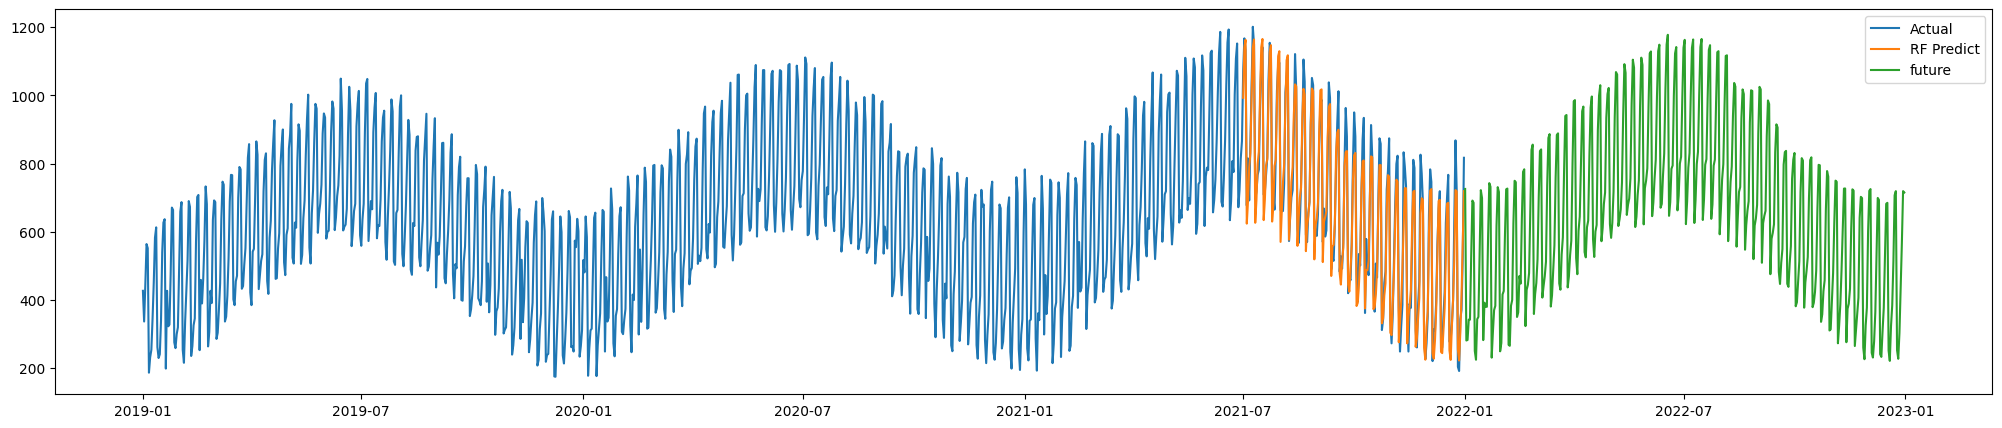

In [ ]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.rf_pred, label = "RF Predict")
plt.plot(future_predictors.predictions, label = "future")
plt.legend()
plt.show()

# Forecasting using Deep Learning


In [ ]:
time_ser = data.groupby('date').agg({'sales_amnt': 'sum'})
time_ser

sales_amnt
date                  
2019-01-01     4023.00
2019-01-02     3074.69
2019-01-03     4062.71
2019-01-04     5006.81
2019-01-05     4927.53
...                ...
2021-12-27     1867.71
2021-12-28     3426.50
2021-12-29     3715.39
2021-12-30     5266.27
2021-12-31     8287.81

[1096 rows x 1 columns]

## Define the train and test series

In [ ]:
train = time_ser[time_ser.index < '2021-07-01']
test = time_ser[time_ser.index >= '2021-07-01']

## data scaling

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Generate synthetic data

In [ ]:
# We're only using one feature here
n_features = 1
length = 12

In [ ]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Build and train LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

## fit model

In [ ]:
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
 14/900 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.1477

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0472 - val_loss: 0.0449
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0309 - val_loss: 0.0187
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0159 - val_loss: 0.0123
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0118 - val_loss: 0.0088
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0088 - val_loss: 0.0095
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0069 - val_loss: 0.0157
Epoch 9/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 10/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 11/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 12/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss:

<Axes: >

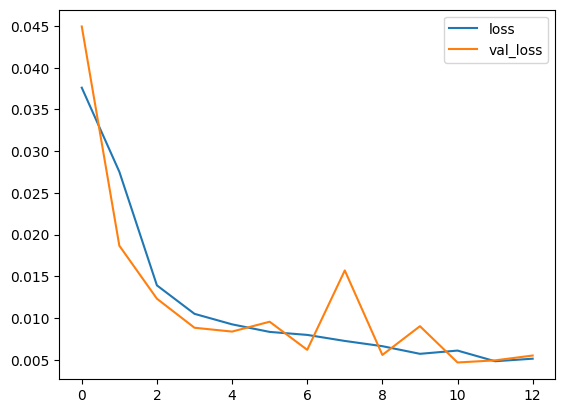

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

# Make predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

<ipython-input-111-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [ ]:
test

sales_amnt   Predictions
date                                
2021-07-01    10290.33   9410.960750
2021-07-02    11028.59  11561.378806
2021-07-03    10793.51  10922.906425
2021-07-04     6524.13   7229.029408
2021-07-05     7983.57   7299.208164
...                ...           ...
2021-12-27     1867.71  11225.723656
2021-12-28     3426.50  10275.832263
2021-12-29     3715.39  10207.614273
2021-12-30     5266.27  10750.836872
2021-12-31     8287.81  11290.484272

[184 rows x 2 columns]

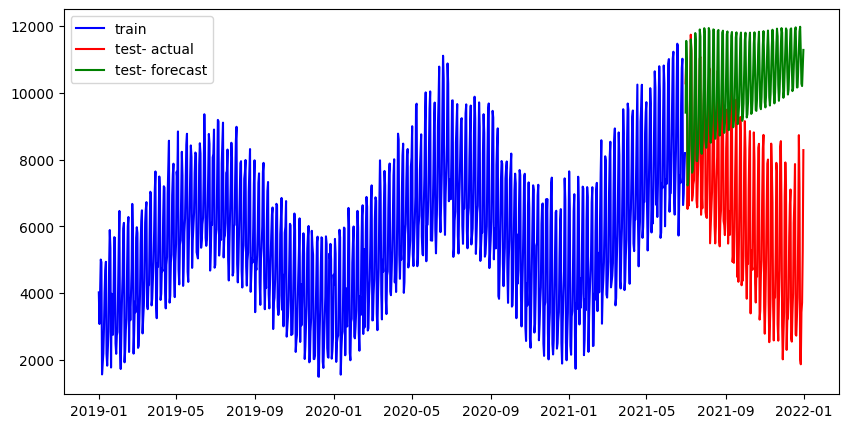

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test.sales_amnt, color = 'red', label = 'test- actual')
plt.plot(test.index, test.Predictions,color = 'green', label = 'test- forecast')
plt.legend()
plt.show()

test.plot(figsize=(12,8))

## Calculate MAPE

In [ ]:
mape_dl = mean_absolute_percentage_error(y_true = test.sales_amnt, y_pred = test.Predictions)
print("MAPE for LSTM : ", mape_dl)

MAPE for LSTM :  0.8811800184654359


In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(time_ser)

In [ ]:
length = 3*30 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(generator,epochs=8)

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   2/1006 ━━━━━━━━━━━━━━━━━━━━ 1:04 64ms/step - loss: 0.0150

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1006/1006 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - loss: 0.0382
Epoch 2/8
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - loss: 178152.8281
Epoch 3/8
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - loss: 0.0399
Epoch 4/8
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - loss: 0.0321
Epoch 5/8
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - loss: 0.0310
Epoch 6/8
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - loss: 0.0310
Epoch 7/8
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - loss: 0.0282
Epoch 8/8
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - loss: 0.0262


In [ ]:
forecast = []
periods = 3*30

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_dates = pd.date_range(start='2022-01-01 ',periods=3*30, freq = "D")

In [ ]:
forecast_data = pd.DataFrame(data=forecast,index=forecast_dates,
                           columns=['Forecast']).squeeze()

In [ ]:
forecast_data

2022-01-01    4918.034445
2022-01-02    4393.944636
2022-01-03    4271.801419
2022-01-04    4352.277320
2022-01-05    4517.239023
                 ...     
2022-03-27    4296.042019
2022-03-28    4238.770398
2022-03-29    4181.821605
2022-03-30    4127.211449
2022-03-31    4073.364176
Freq: D, Name: Forecast, Length: 90, dtype: float64

In [ ]:
time_ser

sales_amnt
date                  
2019-01-01     4023.00
2019-01-02     3074.69
2019-01-03     4062.71
2019-01-04     5006.81
2019-01-05     4927.53
...                ...
2021-12-27     1867.71
2021-12-28     3426.50
2021-12-29     3715.39
2021-12-30     5266.27
2021-12-31     8287.81

[1096 rows x 1 columns]

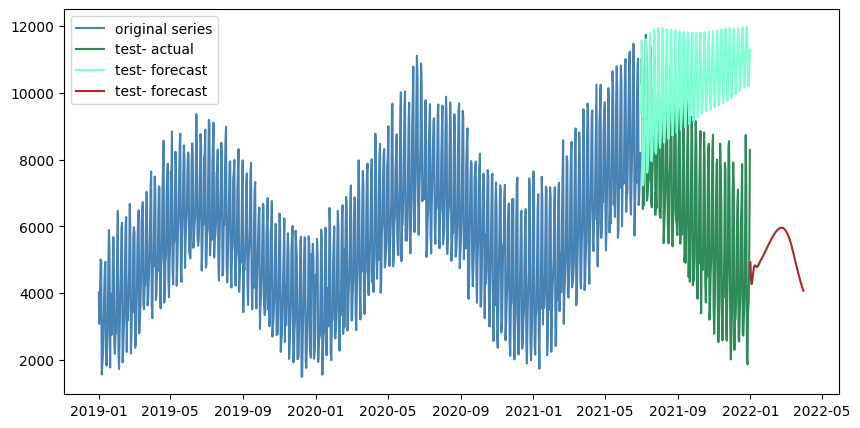

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(train.index, train.sales_amnt, color = 'steelblue', label = 'original series')
plt.plot(test.index, test.sales_amnt,color = 'seagreen', label = 'test- actual')
plt.plot(test.index, test.Predictions,color = 'aquamarine', label = 'test- forecast')
plt.plot(forecast_data.index, forecast_data.values, color = 'brown', label = 'test- forecast')
plt.legend()
plt.show()

In [ ]:

mape_dl

0.8811800184654359

In [ ]:

pd.DataFrame([mape_dl ], index = ['LSTM'])

0
LSTM  0.88118